# **Import Libraries**

In [76]:
import numpy as np
import pandas as pd
import os

# Visualization
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns

# Class Weight Calculation
from sklearn.utils.class_weight import compute_class_weight

# Split Data
from sklearn.model_selection import train_test_split

# Keras Library 
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical, Sequence
from tensorflow.keras.callbacks import EarlyStopping
from keras import regularizers
from keras.callbacks import ReduceLROnPlateau
from keras.metrics import Precision, Recall
from keras.optimizers import Adamax

# Different CNN Model
from tensorflow.keras.applications import VGG16, ResNet50, ResNet101, InceptionResNetV2, InceptionV3, MobileNetV2, DenseNet121, Xception
from tensorflow.keras.applications.efficientnet import EfficientNetB0, EfficientNetB5

# To chain two different data augmented images for training
from itertools import chain

# Model Evaluation
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

# Distributed Computing
import tensorflow as tf

# **Data Splitting**

In [2]:
# Generate data paths with labels
data_dir = 'D:/AI Datasets/Chest X-Ray_Pneumonia/chest_xray/pneumonia_detection/train'
filepaths = []
labels = []

folds = os.listdir(data_dir)
for fold in folds:
    foldpath = os.path.join(data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
df = pd.concat([Fseries, Lseries], axis= 1)

print(df)

                                              filepaths     labels
0     D:/AI Datasets/Chest X-Ray_Pneumonia/chest_xra...     NORMAL
1     D:/AI Datasets/Chest X-Ray_Pneumonia/chest_xra...     NORMAL
2     D:/AI Datasets/Chest X-Ray_Pneumonia/chest_xra...     NORMAL
3     D:/AI Datasets/Chest X-Ray_Pneumonia/chest_xra...     NORMAL
4     D:/AI Datasets/Chest X-Ray_Pneumonia/chest_xra...     NORMAL
...                                                 ...        ...
5211  D:/AI Datasets/Chest X-Ray_Pneumonia/chest_xra...  PNEUMONIA
5212  D:/AI Datasets/Chest X-Ray_Pneumonia/chest_xra...  PNEUMONIA
5213  D:/AI Datasets/Chest X-Ray_Pneumonia/chest_xra...  PNEUMONIA
5214  D:/AI Datasets/Chest X-Ray_Pneumonia/chest_xra...  PNEUMONIA
5215  D:/AI Datasets/Chest X-Ray_Pneumonia/chest_xra...  PNEUMONIA

[5216 rows x 2 columns]


In [3]:
# Split Dataframe for training and validation + testing
train_df, dummy_df = train_test_split(df,  train_size= 0.8, shuffle= True, random_state= 123)

# Split Dataframe for validation and testing
val_df, test_df = train_test_split(dummy_df,  train_size= 0.5, shuffle= True, random_state= 123)

# **Data Augmentation**

In [4]:
# Augmentation data generator
aug_gen = ImageDataGenerator(
            rescale=1./255,
            rotation_range=10,
            width_shift_range=0.1,
            height_shift_range=0.1,
            shear_range=0.1,
            zoom_range=0.1,
            brightness_range = [0.9,1.1],
            horizontal_flip=False,
            vertical_flip=False,
            fill_mode='nearest'                                   
        )
print("Augmented Data Generator created")

# Original data generator
tr_gen = ImageDataGenerator(rescale=1./255)
print("Train Data Generator created")

ts_gen = ImageDataGenerator(rescale=1./255)
print("Test Data Generator created")

# Un-rescaled Data for ResNet and EfficientNet
# Augmentation data generator
aug_gen_un = ImageDataGenerator(
            rotation_range=10,
            width_shift_range=0.1,
            height_shift_range=0.1,
            shear_range=0.1,
            zoom_range=0.1,
            brightness_range = [0.9,1.1],
            horizontal_flip=False,
            vertical_flip=False,
            fill_mode='nearest'                                   
        )
print("Un-rescaled Augmented Data Generator created")

# Original data generator
def scalar (img):
    return img

tr_gen_un = ImageDataGenerator(preprocessing_function=scalar)
print("Un-rescaled Train Data Generator created")

ts_gen_un = ImageDataGenerator(preprocessing_function=scalar)
print("Un-rescaled Test Data Generator created")

Augmented Data Generator created
Train Data Generator created
Test Data Generator created
Un-rescaled Augmented Data Generator created
Un-rescaled Train Data Generator created
Un-rescaled Test Data Generator created


# **Generate Train, Validation, and Test Dataset**

In [5]:
BATCH_SIZE = 16
image_height = 224
image_width = 224

In [6]:
# Train Dataset
train_generator1 = aug_gen.flow_from_dataframe(
    train_df,
    x_col = "filepaths",
    y_col = "labels",
    color_mode = "rgb",
    target_size = (image_height, image_width),
    class_mode = "categorical",
    batch_size = BATCH_SIZE,
    shuffle = True,
    seed = 42)

train_generator2 = tr_gen.flow_from_dataframe(
    train_df,
    x_col = "filepaths",
    y_col = "labels",
    color_mode = "rgb",
    target_size = (image_height, image_width),
    class_mode = "categorical",
    batch_size = BATCH_SIZE,
    shuffle = True,
    seed = 42)

train_generator1_unrescaled = aug_gen_un.flow_from_dataframe(
    train_df,
    x_col = "filepaths",
    y_col = "labels",
    color_mode = "rgb",
    target_size = (image_height, image_width),
    class_mode = "categorical",
    batch_size = BATCH_SIZE,
    shuffle = True,
    seed = 42)

train_generator2_unrescaled = tr_gen_un.flow_from_dataframe(
    train_df,
    x_col = "filepaths",
    y_col = "labels",
    color_mode = "rgb",
    target_size = (image_height, image_width),
    class_mode = "categorical",
    batch_size = BATCH_SIZE,
    shuffle = True,
    seed = 42)

print('Train data set created\n')


# Validation Dataset
val_generator = ts_gen.flow_from_dataframe(
    val_df,
    x_col = "filepaths",
    y_col = "labels",
    color_mode = "rgb",
    target_size = (image_height, image_width),
    class_mode = "categorical",
    batch_size = BATCH_SIZE,
    shuffle = True,
    seed = 42)

val_generator_unrescaled = ts_gen_un.flow_from_dataframe(
    val_df,
    x_col = "filepaths",
    y_col = "labels",
    color_mode = "rgb",
    target_size = (image_height, image_width),
    class_mode = "categorical",
    batch_size = BATCH_SIZE,
    shuffle = True,
    seed = 42)

print('Validation data set created\n')


# Test Dataset
test_generator = ts_gen.flow_from_dataframe(
    test_df,
    x_col = "filepaths",
    y_col = "labels",
    color_mode = "rgb",
    target_size = (image_height, image_width),
    class_mode = "categorical",
    batch_size = BATCH_SIZE,
    shuffle = False)

test_generator_unrescaled = ts_gen_un.flow_from_dataframe(
    test_df,
    x_col = "filepaths",
    y_col = "labels",
    color_mode = "rgb",
    target_size = (image_height, image_width),
    class_mode = "categorical",
    batch_size = BATCH_SIZE,
    shuffle = False)

print('Test data set created\n')

Found 4172 validated image filenames belonging to 2 classes.
Found 4172 validated image filenames belonging to 2 classes.
Found 4172 validated image filenames belonging to 2 classes.
Found 4172 validated image filenames belonging to 2 classes.
Train data set created

Found 522 validated image filenames belonging to 2 classes.
Found 522 validated image filenames belonging to 2 classes.
Validation data set created

Found 522 validated image filenames belonging to 2 classes.
Found 522 validated image filenames belonging to 2 classes.
Test data set created



# **Exploratory Data Analysis (EDA)**

In [7]:
dict_class = train_generator1.class_indices
print('Dictionary: {}'.format(dict_class))
class_names = list(dict_class.keys())
print('Class labels: {}'.format(class_names))

Dictionary: {'NORMAL': 0, 'PNEUMONIA': 1}
Class labels: ['NORMAL', 'PNEUMONIA']


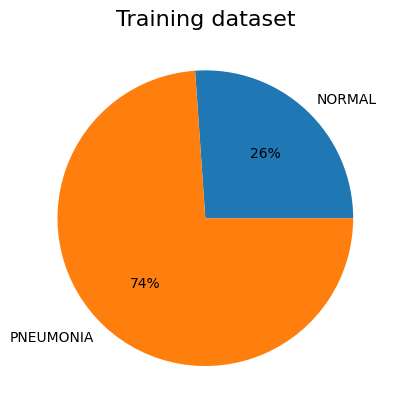

In [8]:
# Data frequency for each class
frequency = np.unique(train_generator1.classes, return_counts=True)

plt.title("Training dataset", fontsize='16')
plt.pie(frequency[1], labels = class_names, autopct='%1.0f%%');

In [9]:
# Train dataset characteristics
print("Dataset Characteristics of Train Data Set:")
print("Number of images:", len(train_generator1.classes))
print("Number of normal images:", len([label for label in train_generator1.classes if label == 0]))
print("Number of pneumonia images:", len([label for label in train_generator1.classes if label == 1]))
print()

# Validation dataset characteristics
print("Dataset Characteristics of Validation Data Set:")
print("Number of images:", len(val_generator.classes))
print("Number of normal images:", len([label for label in val_generator.classes if label == 0]))
print("Number of pneumonia images:", len([label for label in val_generator.classes if label == 1]))
print()

# Test dataset characteristics
print("Dataset Characteristics of Test Data Set:")
print("Number of images:", len(test_generator.classes))
print("Number of normal images:", len([label for label in test_generator.classes if label == 0]))
print("Number of pneumonia images:", len([label for label in test_generator.classes if label == 1]))
print()

Dataset Characteristics of Train Data Set:
Number of images: 4172
Number of normal images: 1089
Number of pneumonia images: 3083

Dataset Characteristics of Validation Data Set:
Number of images: 522
Number of normal images: 116
Number of pneumonia images: 406

Dataset Characteristics of Test Data Set:
Number of images: 522
Number of normal images: 136
Number of pneumonia images: 386



# **Class Weights for Balancing**

In [10]:
class_weights = compute_class_weight(class_weight = "balanced", classes= np.unique(train_generator1.classes), y= train_generator1.classes)
class_weights = dict(zip(np.unique(train_generator1.classes), class_weights))
class_weights

{0: 1.9155188246097337, 1: 0.6766136879662666}

Train image dataset 1


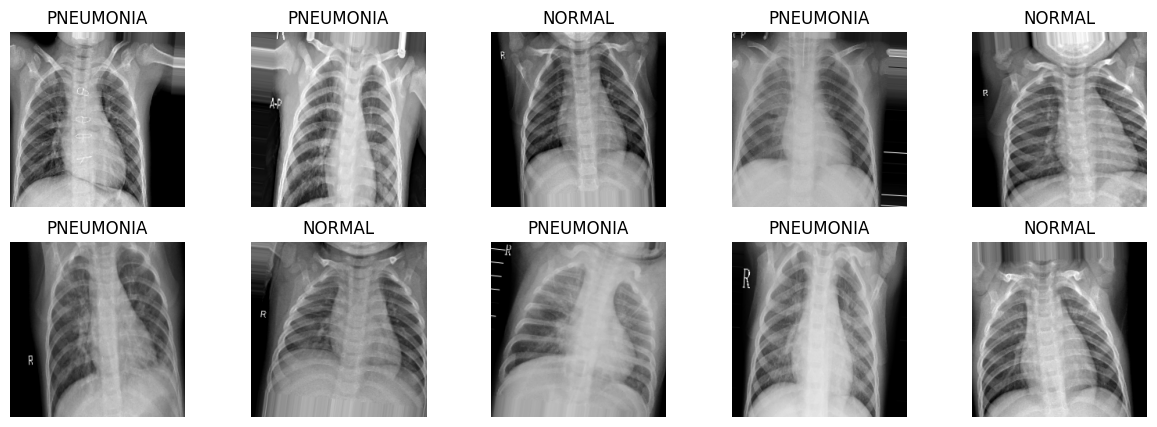

Train image dataset 2


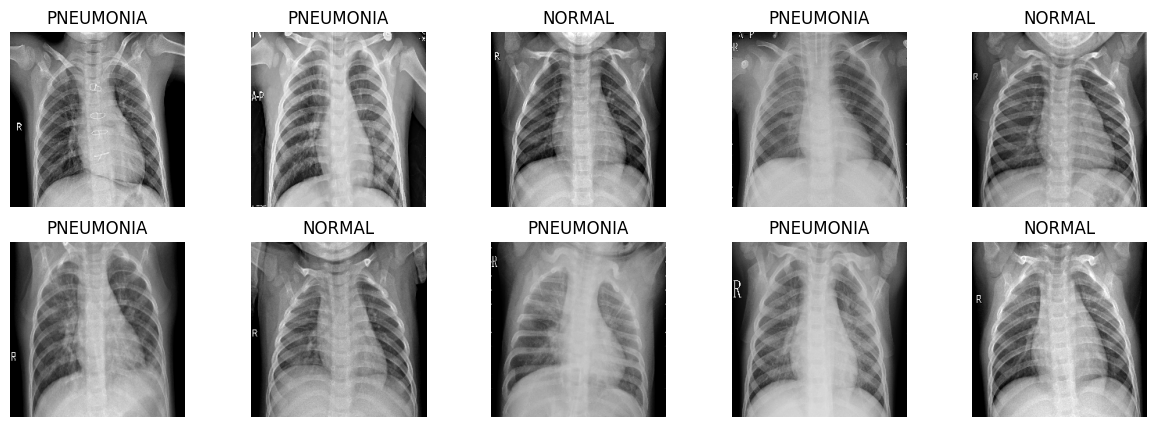

Train image dataset 1 un-rescaled


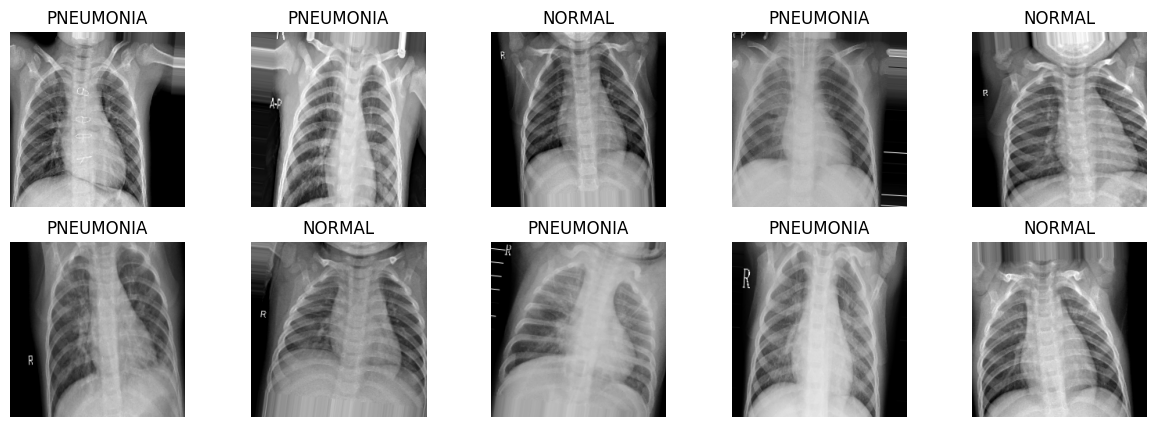

In [11]:
# Image Samples
print('Train image dataset 1')
img, label = next(train_generator1)

plt.figure(figsize=[15, 5])
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(img[i])
    plt.axis('off')
    plt.title(class_names[np.argmax(label[i])])    
plt.show()


print('Train image dataset 2')
img, label = next(train_generator2)

plt.figure(figsize=[15, 5])
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(img[i])
    plt.axis('off')
    plt.title(class_names[np.argmax(label[i])])    
plt.show()


print('Train image dataset 1 un-rescaled')
img, label = next(train_generator1_unrescaled)

plt.figure(figsize=[15, 5])
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(img[i] / 255)
    plt.axis('off')
    plt.title(class_names[np.argmax(label[i])])    
plt.show()

# **Model Building**

In [12]:
# Check Availability of GPU
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [13]:
# Merge Data Generator using Sequence
class MergedDataGenerator(Sequence):
    def __init__(self, gen1, gen2):
        self.gen1 = gen1
        self.gen2 = gen2
        self.total_samples = gen1.samples + gen2.samples
        self.batch_size = gen1.batch_size
    
    def __len__(self):
        return int(np.ceil(self.total_samples / self.batch_size))
    
    def __getitem__(self, idx):
        # Load batches alternately from gen1 and gen2
        if idx % 2 == 0:
            return self.gen1[idx // 2]
        else:
            return self.gen2[idx // 2]

In [73]:
# Define the epochs for training 
EPOCHS = 10

# Merge augmented image data for training
merged_train_generator = MergedDataGenerator(train_generator1, train_generator2)
merged_train_generator_unrescaled = MergedDataGenerator(train_generator1_unrescaled, train_generator2_unrescaled)

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, verbose=1, restore_best_weights=True)

# Define dataset for training
train_data = merged_train_generator
train_data_unrescaled = merged_train_generator_unrescaled

# Dictionary for storing roc value
roc_data = {}

# **VGG16**

In [15]:
# Load the pre-trained VGG16 model without the top classification layer
base_model_VGG16 = VGG16(weights='imagenet', include_top=False, input_shape=(image_height, image_width, 3))

# Set the layers of the base model as non-trainable (freeze them)
for layer in base_model_VGG16.layers:
    layer.trainable = False

# Create a new model and add the VGG16 base model
model_VGG16 = Sequential()
model_VGG16.add(base_model_VGG16)

# Add a custom top layer for classification
model_VGG16.add(GlobalAveragePooling2D())
model_VGG16.add(Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.001)))
model_VGG16.add(Dropout(0.4))
model_VGG16.add(Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.001)))
model_VGG16.add(Dropout(0.2))
model_VGG16.add(Dense(2, activation='softmax'))

# Model summary
print("VGG16 Model")
model_VGG16.summary()

VGG16 Model
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 128)               65664     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                            

In [16]:
# Compile the model
model_VGG16.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history_VGG16 = model_VGG16.fit(train_data, epochs=EPOCHS, validation_data=val_generator, callbacks=[early_stopping], class_weight=class_weights)

Epoch 1/10
522/522 [==============================] - 89s 158ms/step - loss: 0.4383 - accuracy: 0.8488 - val_loss: 0.3459 - val_accuracy: 0.8831
Epoch 2/10
522/522 [==============================] - 77s 147ms/step - loss: 0.2961 - accuracy: 0.9098 - val_loss: 0.2160 - val_accuracy: 0.9502
Epoch 3/10
522/522 [==============================] - 77s 148ms/step - loss: 0.2643 - accuracy: 0.9217 - val_loss: 0.3997 - val_accuracy: 0.8544
Epoch 4/10
522/522 [==============================] - 75s 143ms/step - loss: 0.2629 - accuracy: 0.9179 - val_loss: 0.2913 - val_accuracy: 0.8946
Epoch 5/10
522/522 [==============================] - 74s 142ms/step - loss: 0.2484 - accuracy: 0.9232 - val_loss: 0.2648 - val_accuracy: 0.9119
Epoch 5: early stopping


In [120]:
# Validate the model
val_loss_VGG16, val_accuracy_VGG16 = model_VGG16.evaluate(val_generator, steps=len(val_generator))
print(f'Validation Loss: {val_loss_VGG16:.4f}')
print(f'Validation Accuracy: {val_accuracy_VGG16:.4f}')

ResourceExhaustedError: Graph execution error:

Detected at node 'sequential/vgg16/block1_conv2/Relu' defined at (most recent call last):
    File "c:\Users\Lenovo\anaconda3\envs\tf_gpu\lib\runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Users\Lenovo\anaconda3\envs\tf_gpu\lib\runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "c:\Users\Lenovo\anaconda3\envs\tf_gpu\lib\site-packages\ipykernel_launcher.py", line 18, in <module>
      app.launch_new_instance()
    File "c:\Users\Lenovo\anaconda3\envs\tf_gpu\lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
      app.start()
    File "c:\Users\Lenovo\anaconda3\envs\tf_gpu\lib\site-packages\ipykernel\kernelapp.py", line 739, in start
      self.io_loop.start()
    File "c:\Users\Lenovo\anaconda3\envs\tf_gpu\lib\site-packages\tornado\platform\asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\Lenovo\anaconda3\envs\tf_gpu\lib\asyncio\base_events.py", line 603, in run_forever
      self._run_once()
    File "c:\Users\Lenovo\anaconda3\envs\tf_gpu\lib\asyncio\base_events.py", line 1909, in _run_once
      handle._run()
    File "c:\Users\Lenovo\anaconda3\envs\tf_gpu\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "c:\Users\Lenovo\anaconda3\envs\tf_gpu\lib\site-packages\ipykernel\kernelbase.py", line 545, in dispatch_queue
      await self.process_one()
    File "c:\Users\Lenovo\anaconda3\envs\tf_gpu\lib\site-packages\ipykernel\kernelbase.py", line 534, in process_one
      await dispatch(*args)
    File "c:\Users\Lenovo\anaconda3\envs\tf_gpu\lib\site-packages\ipykernel\kernelbase.py", line 437, in dispatch_shell
      await result
    File "c:\Users\Lenovo\anaconda3\envs\tf_gpu\lib\site-packages\ipykernel\ipkernel.py", line 362, in execute_request
      await super().execute_request(stream, ident, parent)
    File "c:\Users\Lenovo\anaconda3\envs\tf_gpu\lib\site-packages\ipykernel\kernelbase.py", line 778, in execute_request
      reply_content = await reply_content
    File "c:\Users\Lenovo\anaconda3\envs\tf_gpu\lib\site-packages\ipykernel\ipkernel.py", line 449, in do_execute
      res = shell.run_cell(
    File "c:\Users\Lenovo\anaconda3\envs\tf_gpu\lib\site-packages\ipykernel\zmqshell.py", line 549, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\Users\Lenovo\anaconda3\envs\tf_gpu\lib\site-packages\IPython\core\interactiveshell.py", line 3075, in run_cell
      result = self._run_cell(
    File "c:\Users\Lenovo\anaconda3\envs\tf_gpu\lib\site-packages\IPython\core\interactiveshell.py", line 3130, in _run_cell
      result = runner(coro)
    File "c:\Users\Lenovo\anaconda3\envs\tf_gpu\lib\site-packages\IPython\core\async_helpers.py", line 128, in _pseudo_sync_runner
      coro.send(None)
    File "c:\Users\Lenovo\anaconda3\envs\tf_gpu\lib\site-packages\IPython\core\interactiveshell.py", line 3334, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\Users\Lenovo\anaconda3\envs\tf_gpu\lib\site-packages\IPython\core\interactiveshell.py", line 3517, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "c:\Users\Lenovo\anaconda3\envs\tf_gpu\lib\site-packages\IPython\core\interactiveshell.py", line 3577, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\Lenovo\AppData\Local\Temp\ipykernel_23176\3223273114.py", line 5, in <module>
      history_VGG16 = model_VGG16.fit(train_data, epochs=EPOCHS, validation_data=val_generator, callbacks=[early_stopping], class_weight=class_weights)
    File "c:\Users\Lenovo\anaconda3\envs\tf_gpu\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Lenovo\anaconda3\envs\tf_gpu\lib\site-packages\keras\engine\training.py", line 1606, in fit
      val_logs = self.evaluate(
    File "c:\Users\Lenovo\anaconda3\envs\tf_gpu\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Lenovo\anaconda3\envs\tf_gpu\lib\site-packages\keras\engine\training.py", line 1947, in evaluate
      tmp_logs = self.test_function(iterator)
    File "c:\Users\Lenovo\anaconda3\envs\tf_gpu\lib\site-packages\keras\engine\training.py", line 1727, in test_function
      return step_function(self, iterator)
    File "c:\Users\Lenovo\anaconda3\envs\tf_gpu\lib\site-packages\keras\engine\training.py", line 1713, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\Lenovo\anaconda3\envs\tf_gpu\lib\site-packages\keras\engine\training.py", line 1701, in run_step
      outputs = model.test_step(data)
    File "c:\Users\Lenovo\anaconda3\envs\tf_gpu\lib\site-packages\keras\engine\training.py", line 1665, in test_step
      y_pred = self(x, training=False)
    File "c:\Users\Lenovo\anaconda3\envs\tf_gpu\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Lenovo\anaconda3\envs\tf_gpu\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "c:\Users\Lenovo\anaconda3\envs\tf_gpu\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Lenovo\anaconda3\envs\tf_gpu\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\Lenovo\anaconda3\envs\tf_gpu\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Lenovo\anaconda3\envs\tf_gpu\lib\site-packages\keras\engine\sequential.py", line 410, in call
      return super().call(inputs, training=training, mask=mask)
    File "c:\Users\Lenovo\anaconda3\envs\tf_gpu\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "c:\Users\Lenovo\anaconda3\envs\tf_gpu\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "c:\Users\Lenovo\anaconda3\envs\tf_gpu\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Lenovo\anaconda3\envs\tf_gpu\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "c:\Users\Lenovo\anaconda3\envs\tf_gpu\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Lenovo\anaconda3\envs\tf_gpu\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\Lenovo\anaconda3\envs\tf_gpu\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Lenovo\anaconda3\envs\tf_gpu\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "c:\Users\Lenovo\anaconda3\envs\tf_gpu\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "c:\Users\Lenovo\anaconda3\envs\tf_gpu\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Lenovo\anaconda3\envs\tf_gpu\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\Lenovo\anaconda3\envs\tf_gpu\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Lenovo\anaconda3\envs\tf_gpu\lib\site-packages\keras\layers\convolutional\base_conv.py", line 314, in call
      return self.activation(outputs)
    File "c:\Users\Lenovo\anaconda3\envs\tf_gpu\lib\site-packages\keras\activations.py", line 317, in relu
      return backend.relu(
    File "c:\Users\Lenovo\anaconda3\envs\tf_gpu\lib\site-packages\keras\backend.py", line 5366, in relu
      x = tf.nn.relu(x)
Node: 'sequential/vgg16/block1_conv2/Relu'
OOM when allocating tensor with shape[16,64,224,224] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node sequential/vgg16/block1_conv2/Relu}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_test_function_4134]

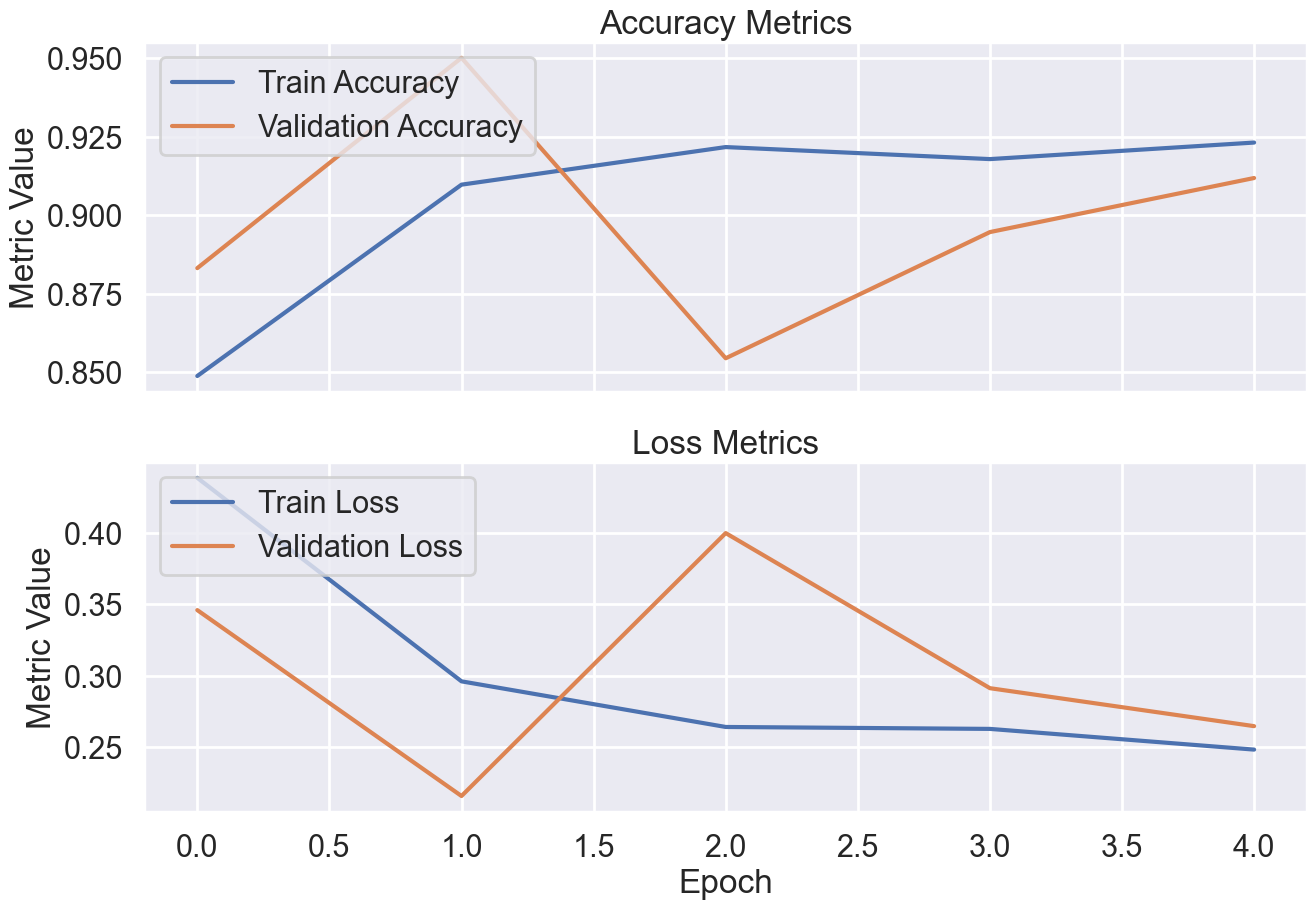

In [ ]:
# Visualize training progression
sns.set_theme()
sns.set_context("poster")

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10), dpi=100, sharex=True)

ax1.plot(history_VGG16.history['accuracy'], label='Train Accuracy')
ax1.plot(history_VGG16.history['val_accuracy'], label='Validation Accuracy')
ax1.set_title('Accuracy Metrics')
ax1.set_ylabel('Metric Value')
ax1.legend(loc='upper left')

ax2.plot(history_VGG16.history['loss'], label='Train Loss')
ax2.plot(history_VGG16.history['val_loss'], label='Validation Loss')
ax2.set_title('Loss Metrics')
ax2.set_ylabel('Metric Value')
ax2.set_xlabel('Epoch')
ax2.legend(loc='upper left')

plt.show()

In [ ]:
# Test the model
test_results = model_VGG16.evaluate(test_generator)
test_predictions = model_VGG16.predict(test_generator)
true_labels = test_generator.labels

# Calculate values for roc curve analysis
test_proba = test_predictions[:, 1]
fpr, tpr, _ = roc_curve(true_labels, test_proba)

# Store values for later
roc_data["VGG16"] = (fpr, tpr, auc(fpr, tpr))

# Create classification report for model
report = classification_report(true_labels, test_predictions.argmax(axis=1), digits=5)
print(report)

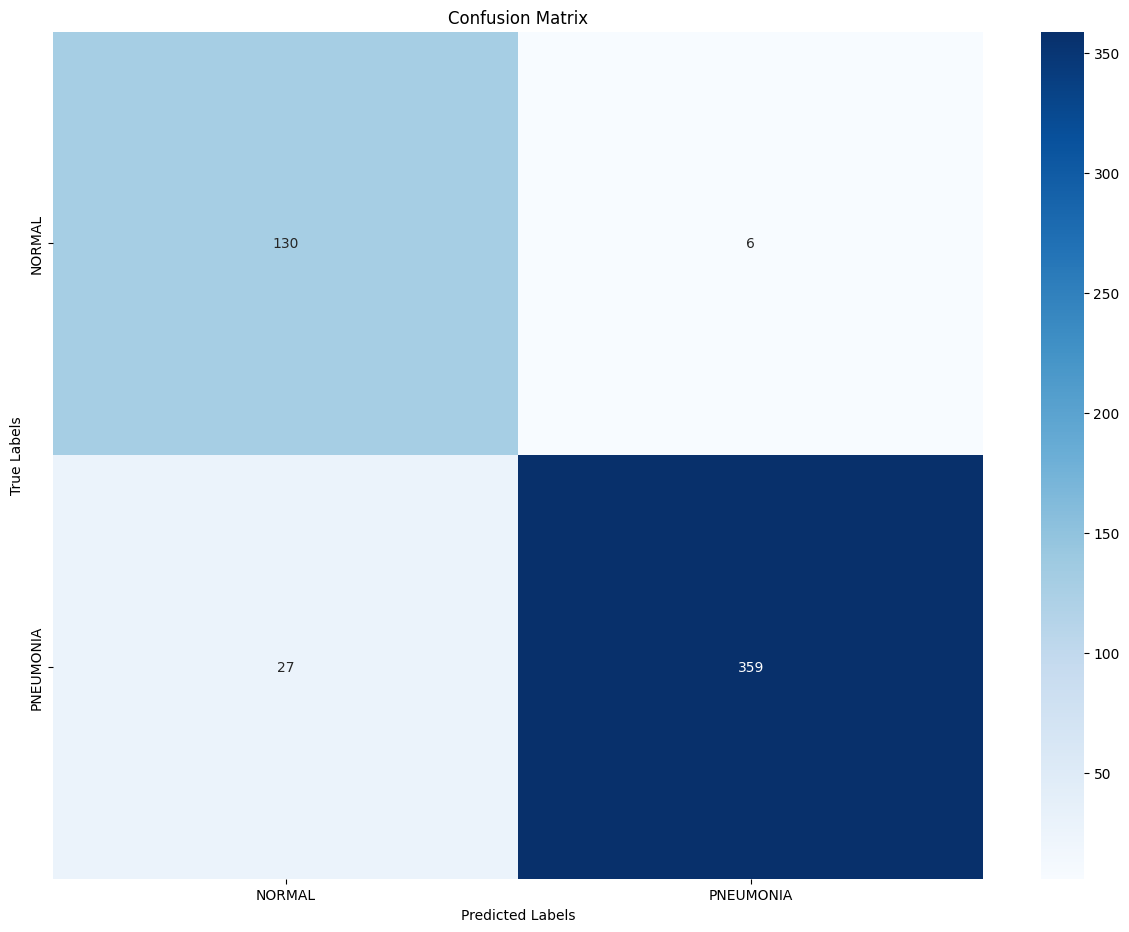

In [20]:
# Confusion Matrix
matrix = confusion_matrix(true_labels, test_predictions.argmax(axis=1))

# Visualization
plt.figure(figsize=(15, 11))
sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(),
            yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# **ResNet50**

In [21]:
# Load the pre-trained ResNet50 model without the top classification layer
base_model_ResNet50 = ResNet50(weights='imagenet', include_top=False, input_shape=(image_height, image_width, 3))

# Set the layers of the base model as non-trainable (freeze them)
for layer in base_model_ResNet50.layers:
    layer.trainable = False

# Create a new model and add the ResNet50 base model
model_ResNet50 = Sequential()
model_ResNet50.add(base_model_ResNet50)

# Add a custom top layer for classification
model_ResNet50.add(GlobalAveragePooling2D())
model_ResNet50.add(Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.001)))
model_ResNet50.add(Dropout(0.4))
model_ResNet50.add(Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.001)))
model_ResNet50.add(Dropout(0.2))
model_ResNet50.add(Dense(2, activation='softmax'))

# Model summary
print("ResNet50 Model")
model_ResNet50.summary()

ResNet50 Model
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_3 (Dense)             (None, 128)               262272    
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                       

In [22]:
# Compile the model
model_ResNet50.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history_ResNet50 = model_ResNet50.fit(train_data_unrescaled, epochs=EPOCHS, validation_data=val_generator_unrescaled, callbacks=[early_stopping], class_weight=class_weights)

Epoch 1/10
522/522 [==============================] - 77s 142ms/step - loss: 0.4145 - accuracy: 0.8992 - val_loss: 0.2704 - val_accuracy: 0.9310
Epoch 2/10
522/522 [==============================] - 73s 140ms/step - loss: 0.2581 - accuracy: 0.9344 - val_loss: 0.1724 - val_accuracy: 0.9636
Epoch 3/10
522/522 [==============================] - 74s 141ms/step - loss: 0.2096 - accuracy: 0.9470 - val_loss: 0.1648 - val_accuracy: 0.9636
Epoch 4/10
522/522 [==============================] - 73s 139ms/step - loss: 0.1807 - accuracy: 0.9494 - val_loss: 0.1840 - val_accuracy: 0.9406
Epoch 5/10
522/522 [==============================] - 74s 142ms/step - loss: 0.1777 - accuracy: 0.9481 - val_loss: 0.1290 - val_accuracy: 0.9655
Epoch 6/10
522/522 [==============================] - 73s 141ms/step - loss: 0.1721 - accuracy: 0.9473 - val_loss: 0.1269 - val_accuracy: 0.9732
Epoch 7/10
522/522 [==============================] - 73s 140ms/step - loss: 0.1511 - accuracy: 0.9546 - val_loss: 0.1493 - val_ac

In [23]:
# Validate the model
val_loss_ResNet50, val_accuracy_ResNet50 = model_ResNet50.evaluate(val_generator_unrescaled, steps=len(val_generator_unrescaled))
print(f'Validation Loss: {val_loss_ResNet50:.4f}')
print(f'Validation Accuracy: {val_accuracy_ResNet50:.4f}')

33/33 [==============================] - 4s 105ms/step - loss: 0.1269 - accuracy: 0.9732
Validation Loss: 0.1269
Validation Accuracy: 0.9732


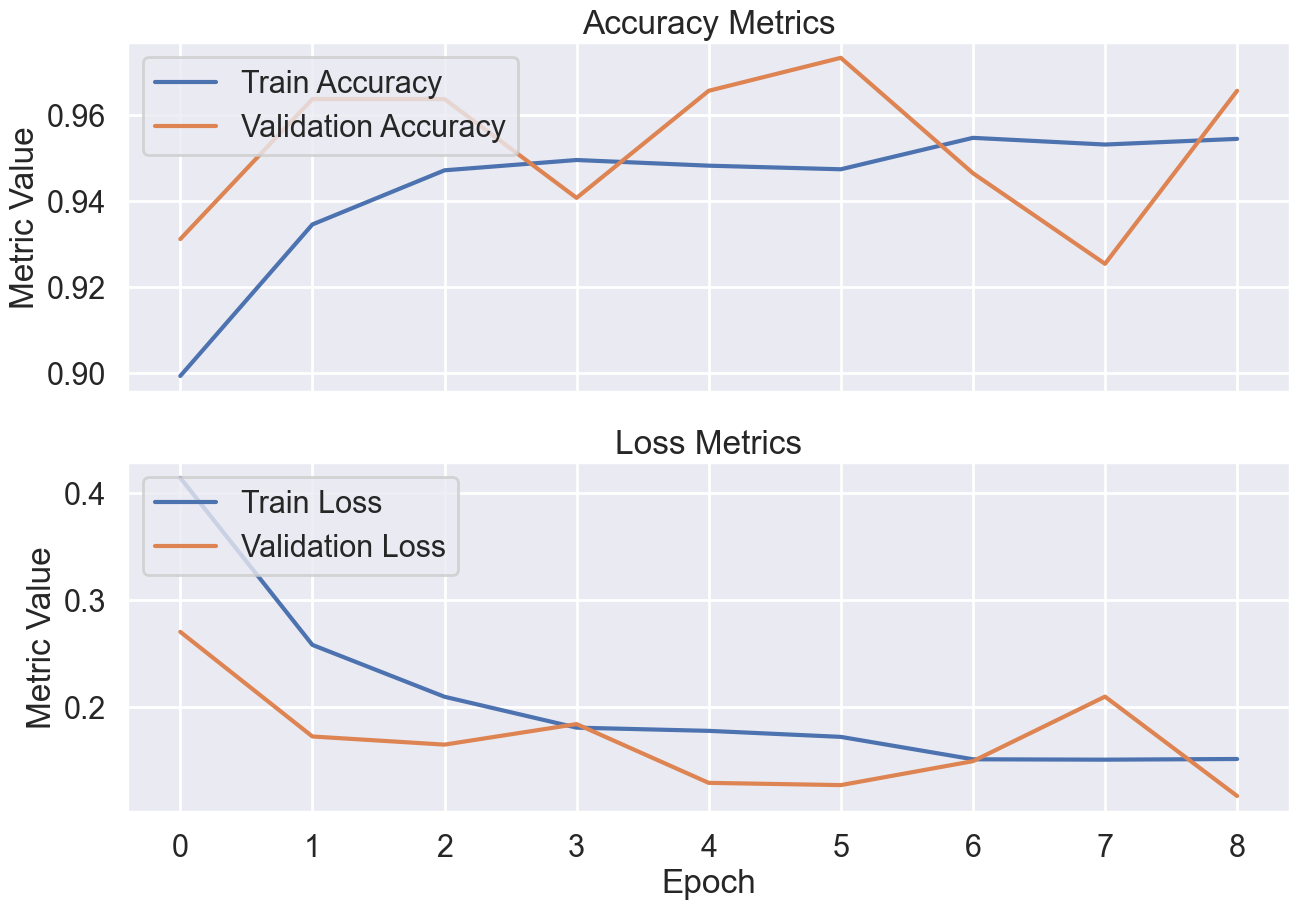

In [101]:
# Visualize training progression
sns.set_theme()
sns.set_context("poster")

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10), dpi=100, sharex=True)

ax1.plot(history_ResNet50.history['accuracy'], label='Train Accuracy')
ax1.plot(history_ResNet50.history['val_accuracy'], label='Validation Accuracy')
ax1.set_title('Accuracy Metrics')
ax1.set_ylabel('Metric Value')
ax1.legend(loc='upper left')

ax2.plot(history_ResNet50.history['loss'], label='Train Loss')
ax2.plot(history_ResNet50.history['val_loss'], label='Validation Loss')
ax2.set_title('Loss Metrics')
ax2.set_ylabel('Metric Value')
ax2.set_xlabel('Epoch')
ax2.legend(loc='upper left')

plt.show()

In [102]:
# Test the model
test_results = model_ResNet50.evaluate(test_generator_unrescaled)
test_predictions = model_ResNet50.predict(test_generator_unrescaled)
true_labels = test_generator_unrescaled.labels

# Calculate values for roc curve analysis
test_proba = test_predictions[:, 1]
fpr, tpr, _ = roc_curve(true_labels, test_proba)

# Store values for later
roc_data["ResNet50"] = (fpr, tpr, auc(fpr, tpr))

# Create classification report for model
report = classification_report(true_labels, test_predictions.argmax(axis=1), digits=5)
print(report)

33/33 [==============================] - 4s 112ms/step
              precision    recall  f1-score   support

           0    0.90000   0.99265   0.94406       136
           1    0.99731   0.96114   0.97889       386

    accuracy                        0.96935       522
   macro avg    0.94866   0.97689   0.96147       522
weighted avg    0.97196   0.96935   0.96982       522



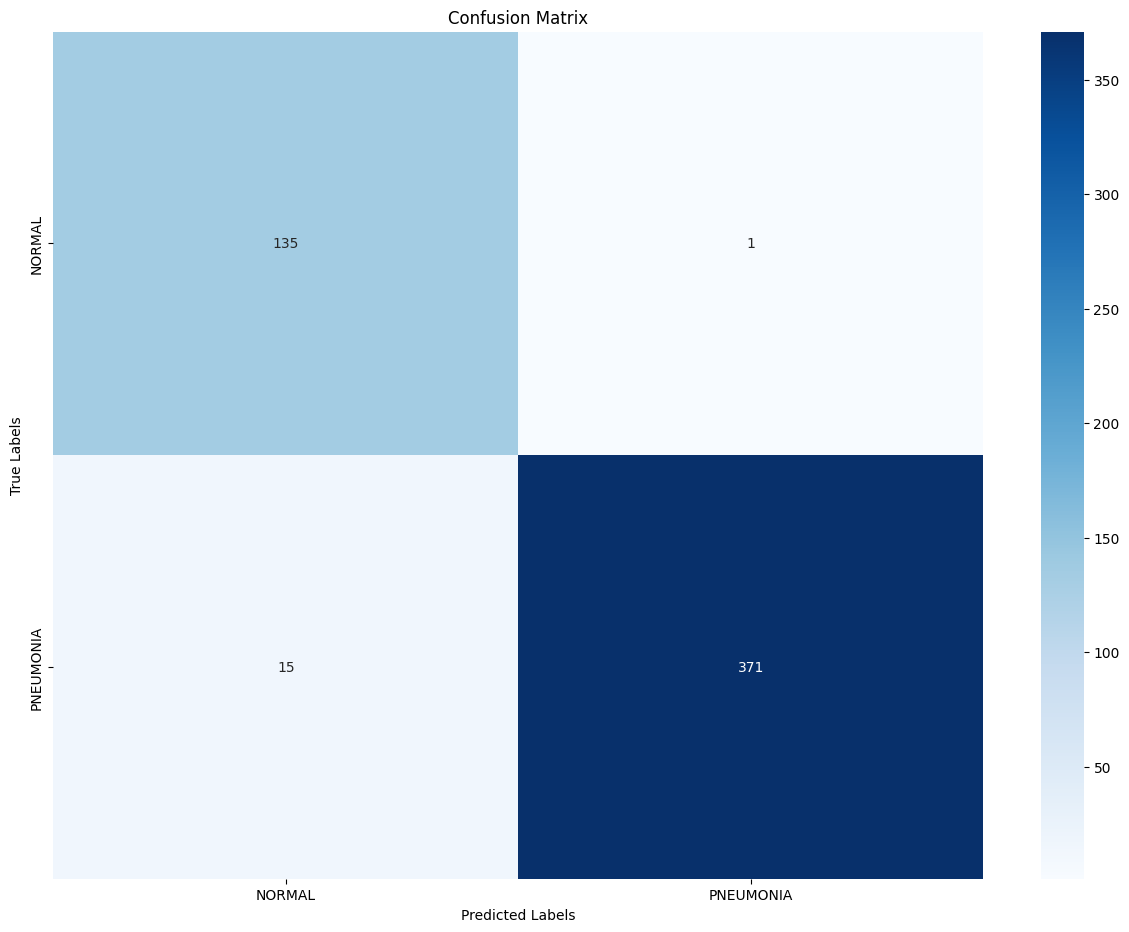

In [25]:
# Confusion Matrix
matrix = confusion_matrix(true_labels, test_predictions.argmax(axis=1))

# Visualization
plt.figure(figsize=(15, 11))
sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator_unrescaled.class_indices.keys(),
            yticklabels=test_generator_unrescaled.class_indices.keys())
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# **ResNet101**

In [26]:
# Load the pre-trained ResNet101 model without the top classification layer
base_model_ResNet101 = ResNet101(weights='imagenet', include_top=False, input_shape=(image_height, image_width, 3))

# Set the layers of the base model as non-trainable (freeze them)
for layer in base_model_ResNet101.layers:
    layer.trainable = False

# Create a new model and add the ResNet101 base model
model_ResNet101 = Sequential()
model_ResNet101.add(base_model_ResNet101)

# Add a custom top layer for classification
model_ResNet101.add(GlobalAveragePooling2D())
model_ResNet101.add(Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.001)))
model_ResNet101.add(Dropout(0.4))
model_ResNet101.add(Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.001)))
model_ResNet101.add(Dropout(0.2))
model_ResNet101.add(Dense(2, activation='softmax'))

# Model summary
print("ResNet101 Model")
model_ResNet101.summary()

ResNet101 Model
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet101 (Functional)      (None, 7, 7, 2048)        42658176  
                                                                 
 global_average_pooling2d_2   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_6 (Dense)             (None, 128)               262272    
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_7 (Dense)             (None, 64)                8256      
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                      

In [27]:
# Compile the model
model_ResNet101.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history_ResNet101 = model_ResNet101.fit(train_data_unrescaled, epochs=EPOCHS, validation_data=val_generator_unrescaled, callbacks=[early_stopping], class_weight=class_weights)

Epoch 1/10
522/522 [==============================] - 85s 154ms/step - loss: 0.4357 - accuracy: 0.8973 - val_loss: 0.3366 - val_accuracy: 0.9042
Epoch 2/10
522/522 [==============================] - 78s 148ms/step - loss: 0.2643 - accuracy: 0.9329 - val_loss: 0.2572 - val_accuracy: 0.9272
Epoch 3/10
522/522 [==============================] - 79s 152ms/step - loss: 0.2244 - accuracy: 0.9409 - val_loss: 0.3243 - val_accuracy: 0.9061
Epoch 4/10
522/522 [==============================] - 77s 147ms/step - loss: 0.2094 - accuracy: 0.9455 - val_loss: 0.2221 - val_accuracy: 0.9444
Epoch 5/10
522/522 [==============================] - 79s 150ms/step - loss: 0.1993 - accuracy: 0.9461 - val_loss: 0.1457 - val_accuracy: 0.9693
Epoch 6/10
522/522 [==============================] - 78s 149ms/step - loss: 0.1758 - accuracy: 0.9449 - val_loss: 0.1888 - val_accuracy: 0.9387
Epoch 7/10
522/522 [==============================] - 79s 150ms/step - loss: 0.1752 - accuracy: 0.9519 - val_loss: 0.1201 - val_ac

In [28]:
# Validate the model
val_loss_ResNet101, val_accuracy_ResNet101 = model_ResNet101.evaluate(val_generator_unrescaled, steps=len(val_generator_unrescaled))
print(f'Validation Loss: {val_loss_ResNet101:.4f}')
print(f'Validation Accuracy: {val_accuracy_ResNet101:.4f}')

33/33 [==============================] - 5s 160ms/step - loss: 0.1399 - accuracy: 0.9655
Validation Loss: 0.1399
Validation Accuracy: 0.9655


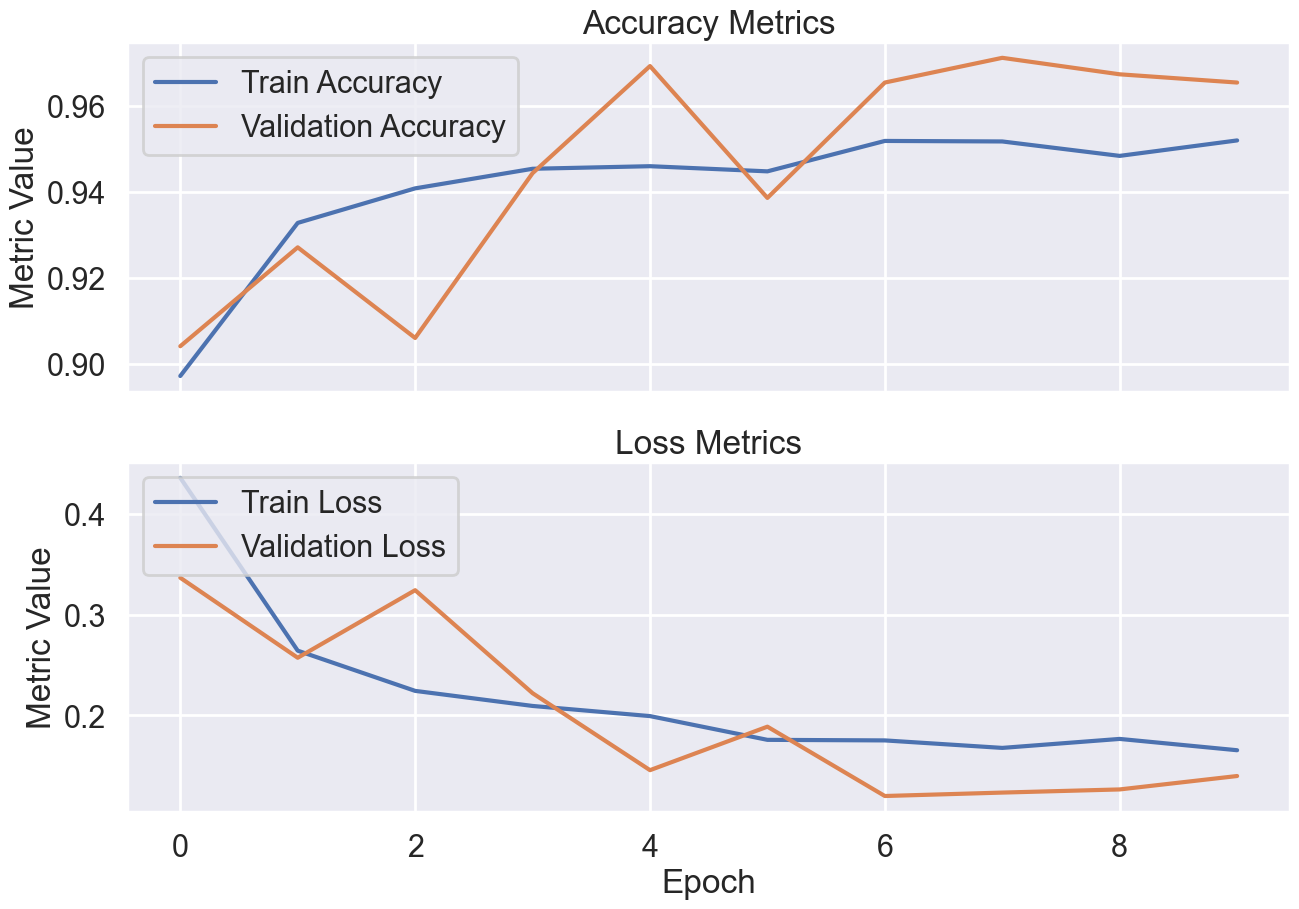

In [103]:
# Visualize training progression
sns.set_theme()
sns.set_context("poster")

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10), dpi=100, sharex=True)

ax1.plot(history_ResNet101.history['accuracy'], label='Train Accuracy')
ax1.plot(history_ResNet101.history['val_accuracy'], label='Validation Accuracy')
ax1.set_title('Accuracy Metrics')
ax1.set_ylabel('Metric Value')
ax1.legend(loc='upper left')

ax2.plot(history_ResNet101.history['loss'], label='Train Loss')
ax2.plot(history_ResNet101.history['val_loss'], label='Validation Loss')
ax2.set_title('Loss Metrics')
ax2.set_ylabel('Metric Value')
ax2.set_xlabel('Epoch')
ax2.legend(loc='upper left')

plt.show()

In [104]:
# Test the model
test_results = model_ResNet101.evaluate(test_generator_unrescaled)
test_predictions = model_ResNet101.predict(test_generator_unrescaled)
true_labels = test_generator_unrescaled.labels

# Calculate values for roc curve analysis
test_proba = test_predictions[:, 1]
fpr, tpr, _ = roc_curve(true_labels, test_proba)

# Store values for later
roc_data["ResNet101"] = (fpr, tpr, auc(fpr, tpr))

# Create classification report for model
report = classification_report(true_labels, test_predictions.argmax(axis=1), digits=5)
print(report)

33/33 [==============================] - 5s 144ms/step
              precision    recall  f1-score   support

           0    0.88742   0.98529   0.93380       136
           1    0.99461   0.95596   0.97490       386

    accuracy                        0.96360       522
   macro avg    0.94101   0.97063   0.95435       522
weighted avg    0.96668   0.96360   0.96419       522



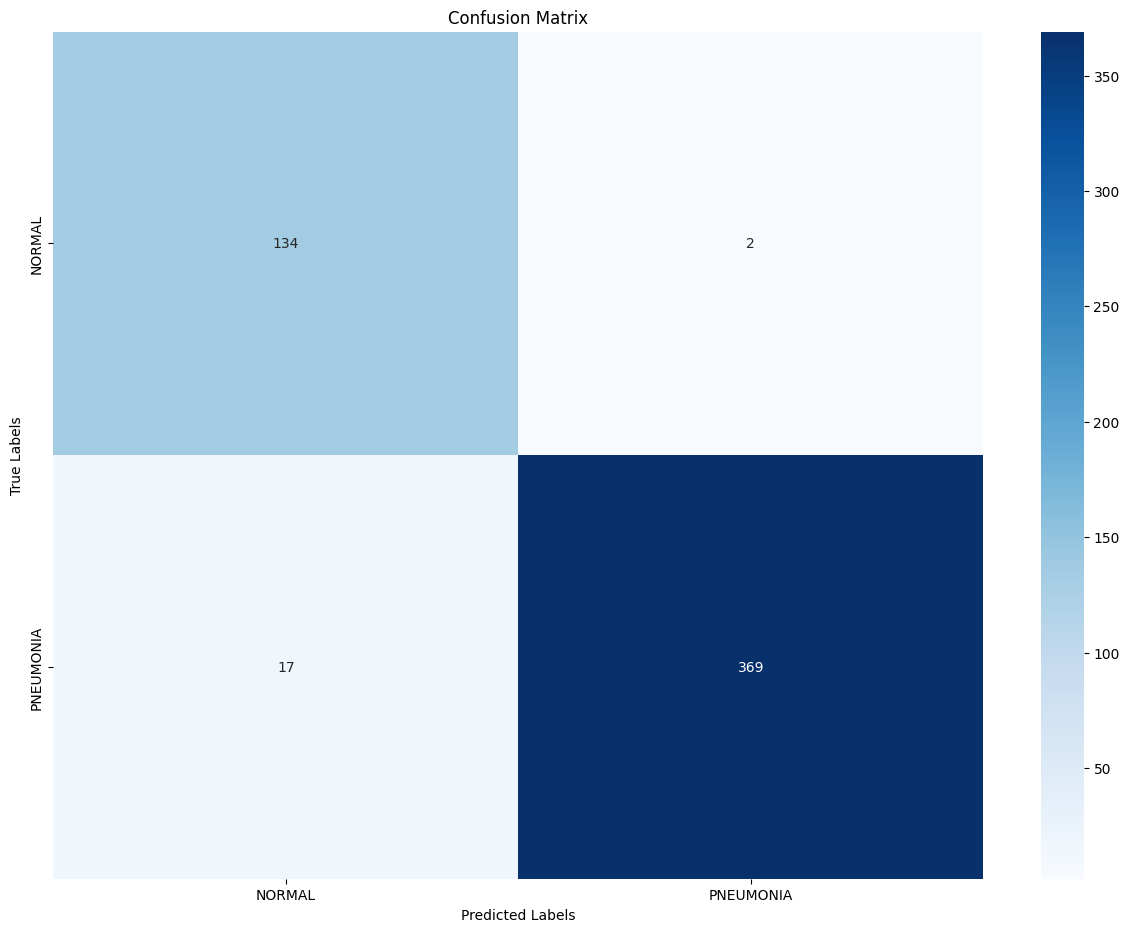

In [30]:
# Confusion Matrix
matrix = confusion_matrix(true_labels, test_predictions.argmax(axis=1))

# Visualization
plt.figure(figsize=(15, 11))
sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator_unrescaled.class_indices.keys(),
            yticklabels=test_generator_unrescaled.class_indices.keys())
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# **InceptionResNetV2**

In [31]:
# Load the pre-trained InceptionResNetV2 model without the top classification layer
base_model_InceptionResNetV2 = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(image_height, image_width, 3))

# Set the layers of the base model as non-trainable (freeze them)
for layer in base_model_InceptionResNetV2.layers:
    layer.trainable = False

# Create a new model and add the InceptionResNetV2 base model
model_InceptionResNetV2 = Sequential()
model_InceptionResNetV2.add(base_model_InceptionResNetV2)

# Add a custom top layer for classification
model_InceptionResNetV2.add(GlobalAveragePooling2D())
model_InceptionResNetV2.add(Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.001)))
model_InceptionResNetV2.add(Dropout(0.4))
model_InceptionResNetV2.add(Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.001)))
model_InceptionResNetV2.add(Dropout(0.2))
model_InceptionResNetV2.add(Dense(2, activation='softmax'))

# Model summary
print("InceptionResNetV2 Model")
model_InceptionResNetV2.summary()

InceptionResNetV2 Model
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v2 (Functi  (None, 5, 5, 1536)       54336736  
 onal)                                                           
                                                                 
 global_average_pooling2d_3   (None, 1536)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_9 (Dense)             (None, 128)               196736    
                                                                 
 dropout_6 (Dropout)         (None, 128)               0         
                                                                 
 dense_10 (Dense)            (None, 64)                8256      
                                                                 
 dropout_7 (Dropout)         (

In [32]:
# Compile the model
model_InceptionResNetV2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history_InceptionResNetV2 = model_InceptionResNetV2.fit(train_data, epochs=EPOCHS, validation_data=val_generator, callbacks=[early_stopping], class_weight=class_weights)

Epoch 1/10
522/522 [==============================] - 132s 236ms/step - loss: 0.5490 - accuracy: 0.8406 - val_loss: 0.6618 - val_accuracy: 0.6992
Epoch 2/10
522/522 [==============================] - 113s 216ms/step - loss: 0.3863 - accuracy: 0.8812 - val_loss: 0.2655 - val_accuracy: 0.9138
Epoch 3/10
522/522 [==============================] - 113s 216ms/step - loss: 0.3057 - accuracy: 0.9027 - val_loss: 0.1800 - val_accuracy: 0.9579
Epoch 4/10
522/522 [==============================] - 110s 210ms/step - loss: 0.2831 - accuracy: 0.9102 - val_loss: 0.2374 - val_accuracy: 0.9215
Epoch 5/10
522/522 [==============================] - 112s 214ms/step - loss: 0.2607 - accuracy: 0.9145 - val_loss: 0.2875 - val_accuracy: 0.8889
Epoch 6/10
522/522 [==============================] - 108s 206ms/step - loss: 0.2494 - accuracy: 0.9178 - val_loss: 0.2205 - val_accuracy: 0.9272
Epoch 6: early stopping


In [33]:
# Validate the model
val_loss_InceptionResNetV2, val_accuracy_InceptionResNetV2 = model_InceptionResNetV2.evaluate(val_generator, steps=len(val_generator))
print(f'Validation Loss: {val_loss_InceptionResNetV2:.4f}')
print(f'Validation Accuracy: {val_accuracy_InceptionResNetV2:.4f}')

33/33 [==============================] - 7s 207ms/step - loss: 0.1800 - accuracy: 0.9579
Validation Loss: 0.1800
Validation Accuracy: 0.9579


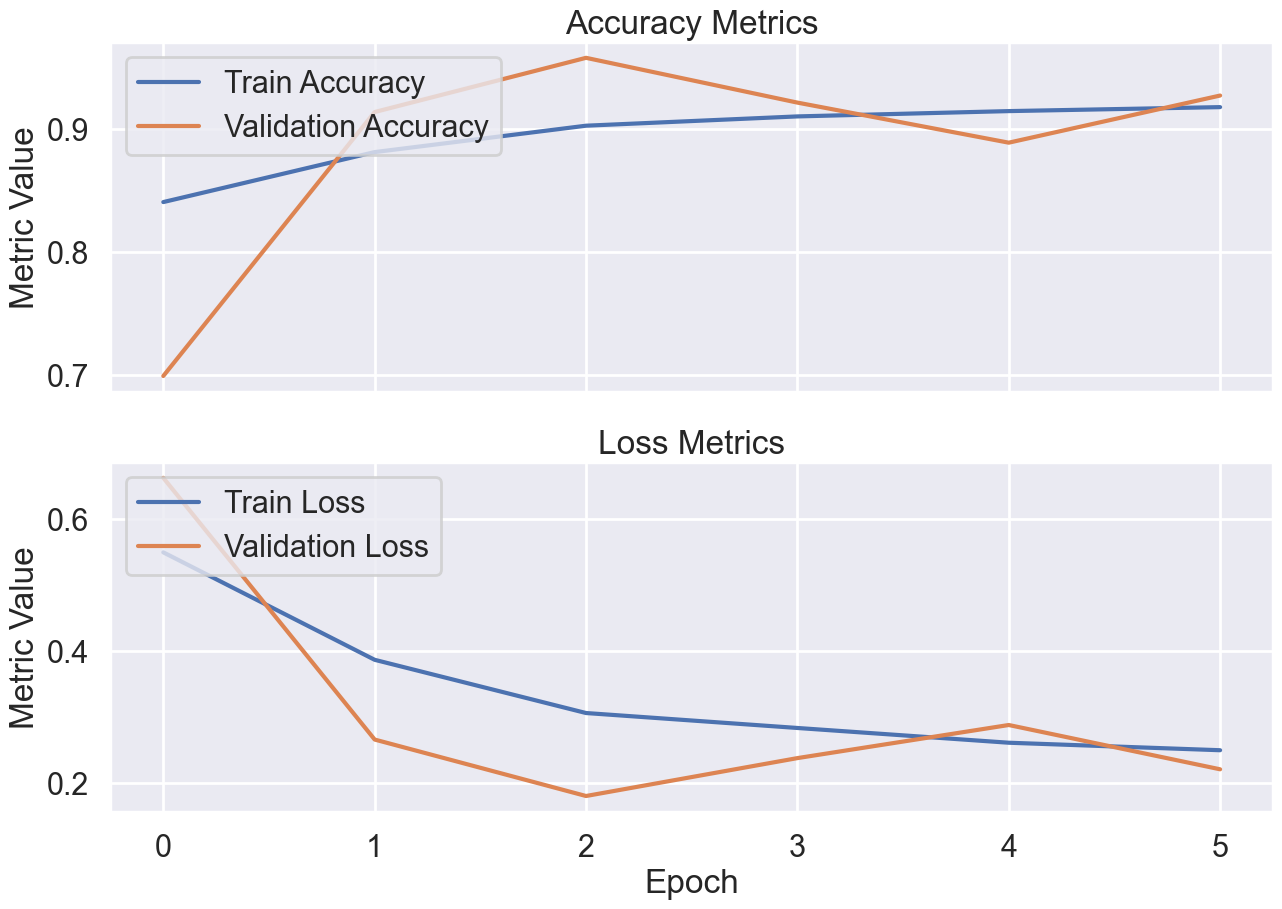

In [105]:
# Visualize training progression
sns.set_theme()
sns.set_context("poster")

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10), dpi=100, sharex=True)

ax1.plot(history_InceptionResNetV2.history['accuracy'], label='Train Accuracy')
ax1.plot(history_InceptionResNetV2.history['val_accuracy'], label='Validation Accuracy')
ax1.set_title('Accuracy Metrics')
ax1.set_ylabel('Metric Value')
ax1.legend(loc='upper left')

ax2.plot(history_InceptionResNetV2.history['loss'], label='Train Loss')
ax2.plot(history_InceptionResNetV2.history['val_loss'], label='Validation Loss')
ax2.set_title('Loss Metrics')
ax2.set_ylabel('Metric Value')
ax2.set_xlabel('Epoch')
ax2.legend(loc='upper left')

plt.show()

In [106]:
# Test the model
test_results = model_InceptionResNetV2.evaluate(test_generator)
test_predictions = model_InceptionResNetV2.predict(test_generator)
true_labels = test_generator.labels

# Calculate values for roc curve analysis
test_proba = test_predictions[:, 1]
fpr, tpr, _ = roc_curve(true_labels, test_proba)

# Store values for later
roc_data["InceptionResNetV2"] = (fpr, tpr, auc(fpr, tpr))

# Create classification report for model
report = classification_report(true_labels, test_predictions.argmax(axis=1), digits=5)
print(report)

33/33 [==============================] - 6s 176ms/step
              precision    recall  f1-score   support

           0    0.92647   0.92647   0.92647       136
           1    0.97409   0.97409   0.97409       386

    accuracy                        0.96169       522
   macro avg    0.95028   0.95028   0.95028       522
weighted avg    0.96169   0.96169   0.96169       522



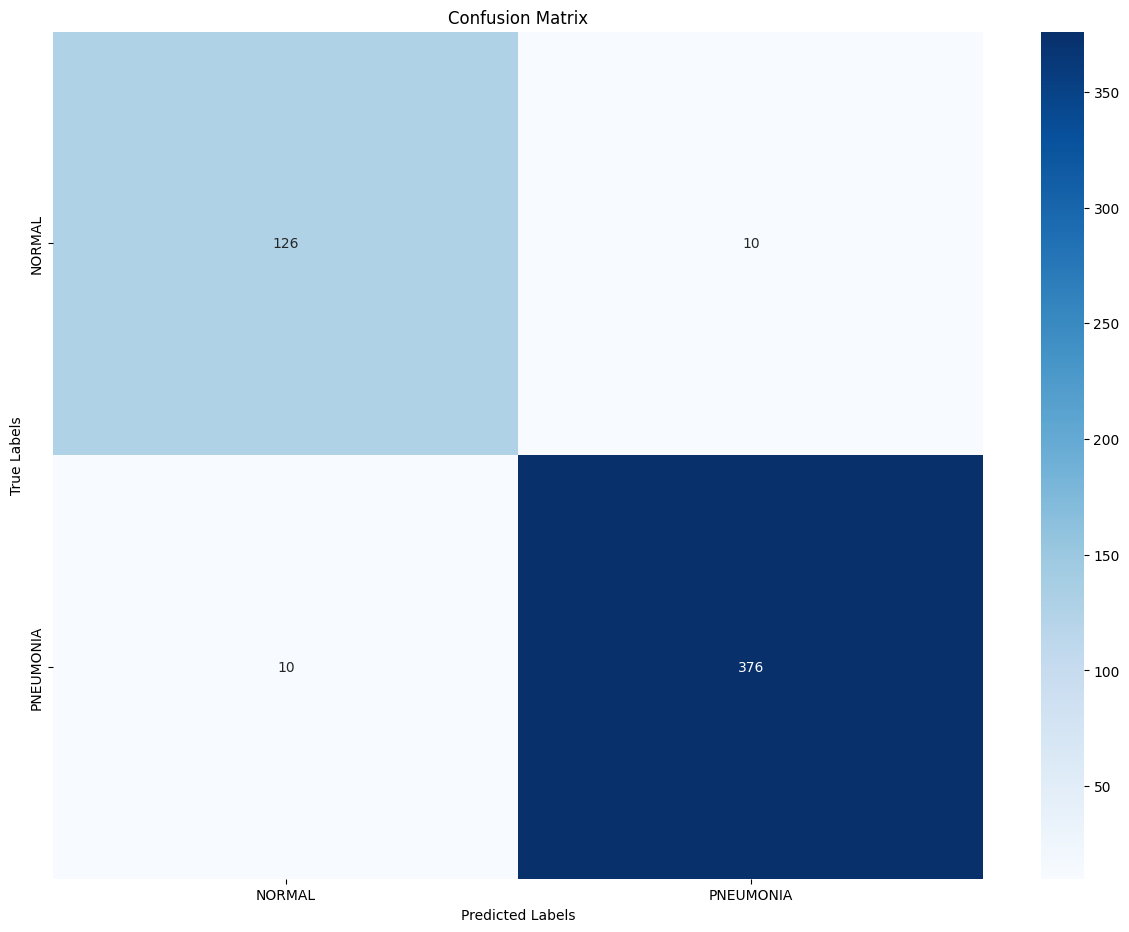

In [35]:
# Confusion Matrix
matrix = confusion_matrix(true_labels, test_predictions.argmax(axis=1))

# Visualization
plt.figure(figsize=(15, 11))
sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(),
            yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# **InceptionV3**

In [36]:
# Load the pre-trained InceptionV3 model without the top classification layer
base_model_InceptionV3 = InceptionV3(weights='imagenet', include_top=False, input_shape=(image_height, image_width, 3))

# Set the layers of the base model as non-trainable (freeze them)
for layer in base_model_InceptionV3.layers:
    layer.trainable = False

# Create a new model and add the InceptionV3 base model
model_InceptionV3 = Sequential()
model_InceptionV3.add(base_model_InceptionV3)

# Add a custom top layer for classification
model_InceptionV3.add(GlobalAveragePooling2D())
model_InceptionV3.add(Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.001)))
model_InceptionV3.add(Dropout(0.4))
model_InceptionV3.add(Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.001)))
model_InceptionV3.add(Dropout(0.2))
model_InceptionV3.add(Dense(2, activation='softmax'))

# Model summary
print("InceptionV3 Model")
model_InceptionV3.summary()

InceptionV3 Model
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 global_average_pooling2d_4   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_12 (Dense)            (None, 128)               262272    
                                                                 
 dropout_8 (Dropout)         (None, 128)               0         
                                                                 
 dense_13 (Dense)            (None, 64)                8256      
                                                                 
 dropout_9 (Dropout)         (None, 64)                0         
                                    

In [37]:
# Compile the model
model_InceptionV3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history_InceptionV3 = model_InceptionV3.fit(train_data, epochs=EPOCHS, validation_data=val_generator, callbacks=[early_stopping], class_weight=class_weights)

Epoch 1/10
522/522 [==============================] - 89s 163ms/step - loss: 0.5347 - accuracy: 0.8545 - val_loss: 0.3674 - val_accuracy: 0.8966
Epoch 2/10
522/522 [==============================] - 83s 159ms/step - loss: 0.3650 - accuracy: 0.8939 - val_loss: 0.3086 - val_accuracy: 0.9080
Epoch 3/10
522/522 [==============================] - 78s 150ms/step - loss: 0.3080 - accuracy: 0.9119 - val_loss: 0.2664 - val_accuracy: 0.9195
Epoch 4/10
522/522 [==============================] - 83s 159ms/step - loss: 0.2739 - accuracy: 0.9104 - val_loss: 0.2800 - val_accuracy: 0.9023
Epoch 5/10
522/522 [==============================] - 85s 164ms/step - loss: 0.2753 - accuracy: 0.9076 - val_loss: 0.2540 - val_accuracy: 0.9061
Epoch 6/10
522/522 [==============================] - 86s 164ms/step - loss: 0.2634 - accuracy: 0.9159 - val_loss: 0.2931 - val_accuracy: 0.9004
Epoch 6: early stopping


In [38]:
# Validate the model
val_loss_InceptionV3, val_accuracy_InceptionV3 = model_InceptionV3.evaluate(val_generator, steps=len(val_generator))
print(f'Validation Loss: {val_loss_InceptionV3:.4f}')
print(f'Validation Accuracy: {val_accuracy_InceptionV3:.4f}')

33/33 [==============================] - 4s 121ms/step - loss: 0.2664 - accuracy: 0.9195
Validation Loss: 0.2664
Validation Accuracy: 0.9195


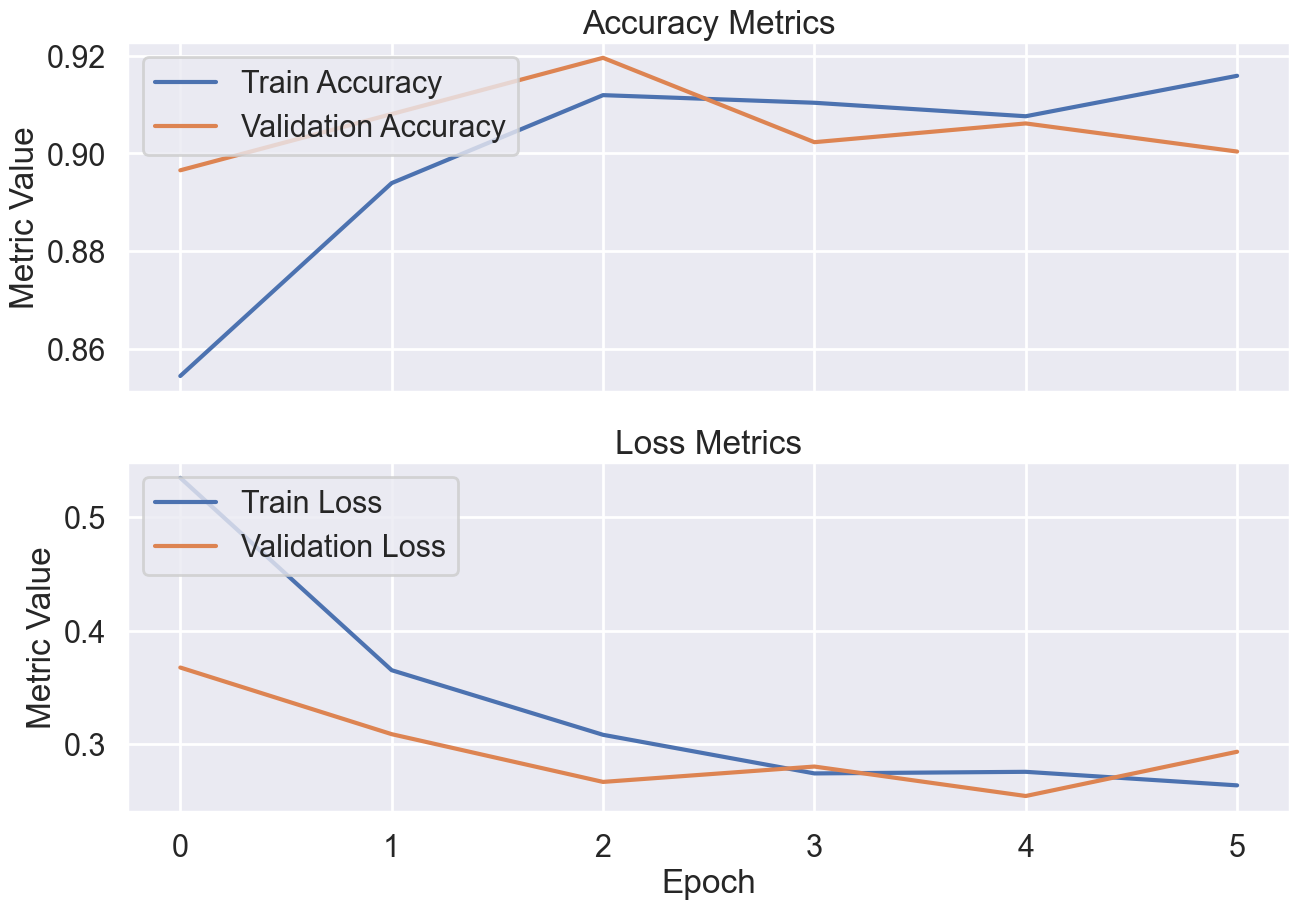

In [107]:
# Visualize training progression
sns.set_theme()
sns.set_context("poster")

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10), dpi=100, sharex=True)

ax1.plot(history_InceptionV3.history['accuracy'], label='Train Accuracy')
ax1.plot(history_InceptionV3.history['val_accuracy'], label='Validation Accuracy')
ax1.set_title('Accuracy Metrics')
ax1.set_ylabel('Metric Value')
ax1.legend(loc='upper left')

ax2.plot(history_InceptionV3.history['loss'], label='Train Loss')
ax2.plot(history_InceptionV3.history['val_loss'], label='Validation Loss')
ax2.set_title('Loss Metrics')
ax2.set_ylabel('Metric Value')
ax2.set_xlabel('Epoch')
ax2.legend(loc='upper left')

plt.show()

In [108]:
# Test the model
test_results = model_InceptionV3.evaluate(test_generator)
test_predictions = model_InceptionV3.predict(test_generator)
true_labels = test_generator.labels

# Calculate values for roc curve analysis
test_proba = test_predictions[:, 1]
fpr, tpr, _ = roc_curve(true_labels, test_proba)

# Store values for later
roc_data["InceptionV3"] = (fpr, tpr, auc(fpr, tpr))

# Create classification report for model
report = classification_report(true_labels, test_predictions.argmax(axis=1), digits=5)
print(report)

33/33 [==============================] - 4s 109ms/step
              precision    recall  f1-score   support

           0    0.72376   0.96324   0.82650       136
           1    0.98534   0.87047   0.92435       386

    accuracy                        0.89464       522
   macro avg    0.85455   0.91685   0.87542       522
weighted avg    0.91719   0.89464   0.89885       522



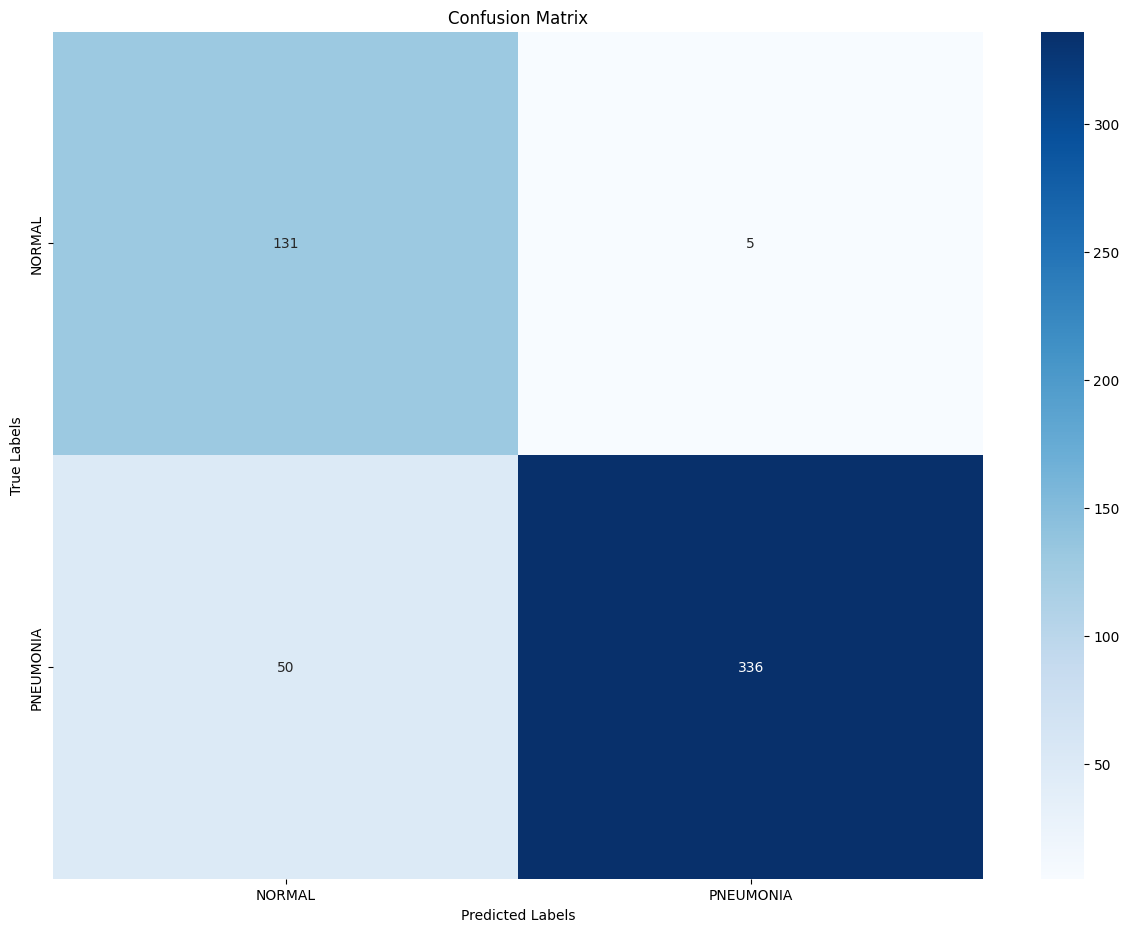

In [40]:
# Confusion Matrix
matrix = confusion_matrix(true_labels, test_predictions.argmax(axis=1))

# Visualization
plt.figure(figsize=(15, 11))
sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(),
            yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# **MobileNetV2**

In [41]:
# Load the pre-trained MobileNetV2 model without the top classification layer
base_model_MobileNetV2 = MobileNetV2(weights='imagenet', include_top=False, input_shape=(image_height, image_width, 3))

# Set the layers of the base model as non-trainable (freeze them)
for layer in base_model_MobileNetV2.layers:
    layer.trainable = False

# Create a new model and add the MobileNetV2 base model
model_MobileNetV2 = Sequential()
model_MobileNetV2.add(base_model_MobileNetV2)

# Add a custom top layer for classification
model_MobileNetV2.add(GlobalAveragePooling2D())
model_MobileNetV2.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model_MobileNetV2.add(Dropout(0.4))
model_MobileNetV2.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model_MobileNetV2.add(Dropout(0.2))
model_MobileNetV2.add(Dense(2, activation='softmax'))

# Model summary
print("MobileNetV2 Model")
model_MobileNetV2.summary()

MobileNetV2 Model
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_5   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_15 (Dense)            (None, 128)               163968    
                                                                 
 dropout_10 (Dropout)        (None, 128)               0         
                                                                 
 dense_16 (Dense)            (None, 64)                8256      
                                                                 
 dropout_11 (Dropout)        (None, 

In [42]:
# Compile the model
model_MobileNetV2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history_MobileNetV2 = model_MobileNetV2.fit(train_data, epochs=EPOCHS, validation_data=val_generator, callbacks=[early_stopping], class_weight=class_weights)

Epoch 1/10
522/522 [==============================] - 81s 150ms/step - loss: 0.4006 - accuracy: 0.9105 - val_loss: 0.2841 - val_accuracy: 0.9464
Epoch 2/10
522/522 [==============================] - 75s 144ms/step - loss: 0.2611 - accuracy: 0.9422 - val_loss: 0.1839 - val_accuracy: 0.9674
Epoch 3/10
522/522 [==============================] - 75s 144ms/step - loss: 0.2222 - accuracy: 0.9443 - val_loss: 0.1453 - val_accuracy: 0.9751
Epoch 4/10
522/522 [==============================] - 75s 143ms/step - loss: 0.1941 - accuracy: 0.9470 - val_loss: 0.1899 - val_accuracy: 0.9464
Epoch 5/10
522/522 [==============================] - 73s 139ms/step - loss: 0.1745 - accuracy: 0.9517 - val_loss: 0.2163 - val_accuracy: 0.9349
Epoch 6/10
522/522 [==============================] - 74s 142ms/step - loss: 0.1696 - accuracy: 0.9510 - val_loss: 0.1374 - val_accuracy: 0.9636
Epoch 6: early stopping


In [43]:
# Validate the model
val_loss_MobileNetV2, val_accuracy_MobileNetV2 = model_MobileNetV2.evaluate(val_generator, steps=len(val_generator))
print(f'Validation Loss: {val_loss_MobileNetV2:.4f}')
print(f'Validation Accuracy: {val_accuracy_MobileNetV2:.4f}')

33/33 [==============================] - 3s 81ms/step - loss: 0.1453 - accuracy: 0.9751
Validation Loss: 0.1453
Validation Accuracy: 0.9751


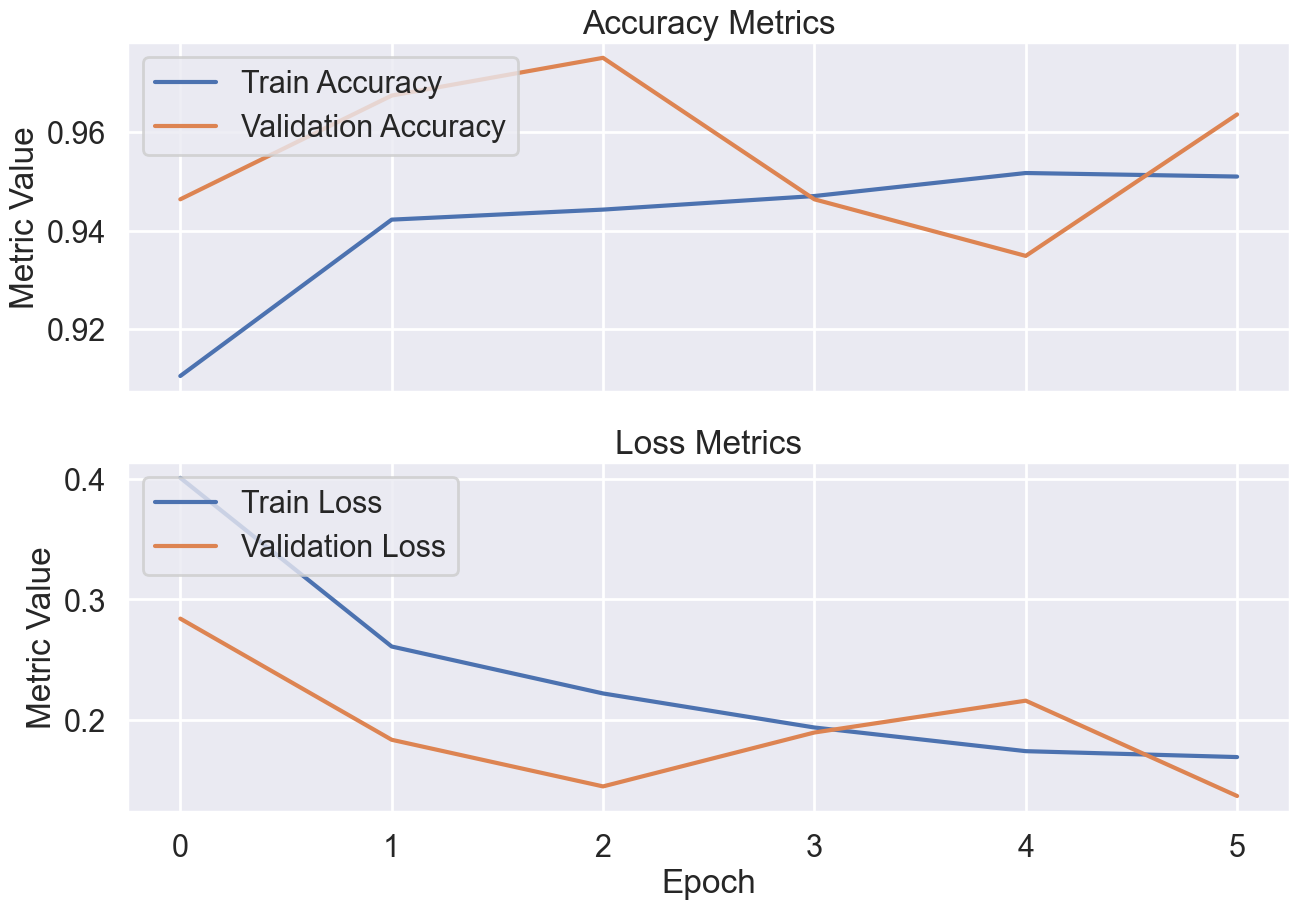

In [109]:
# Visualize training progression
sns.set_theme()
sns.set_context("poster")

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10), dpi=100, sharex=True)

ax1.plot(history_MobileNetV2.history['accuracy'], label='Train Accuracy')
ax1.plot(history_MobileNetV2.history['val_accuracy'], label='Validation Accuracy')
ax1.set_title('Accuracy Metrics')
ax1.set_ylabel('Metric Value')
ax1.legend(loc='upper left')

ax2.plot(history_MobileNetV2.history['loss'], label='Train Loss')
ax2.plot(history_MobileNetV2.history['val_loss'], label='Validation Loss')
ax2.set_title('Loss Metrics')
ax2.set_ylabel('Metric Value')
ax2.set_xlabel('Epoch')
ax2.legend(loc='upper left')

plt.show()

In [110]:
# Test the model
test_results = model_MobileNetV2.evaluate(test_generator)
test_predictions = model_MobileNetV2.predict(test_generator)
true_labels = test_generator.labels

# Calculate values for roc curve analysis
test_proba = test_predictions[:, 1]
fpr, tpr, _ = roc_curve(true_labels, test_proba)

# Store values for later
roc_data["MobileNetV2"] = (fpr, tpr, auc(fpr, tpr))

# Create classification report for model
report = classification_report(true_labels, test_predictions.argmax(axis=1), digits=5)
print(report)

33/33 [==============================] - 3s 95ms/step
              precision    recall  f1-score   support

           0    0.94161   0.94853   0.94505       136
           1    0.98182   0.97927   0.98054       386

    accuracy                        0.97126       522
   macro avg    0.96171   0.96390   0.96280       522
weighted avg    0.97134   0.97126   0.97130       522



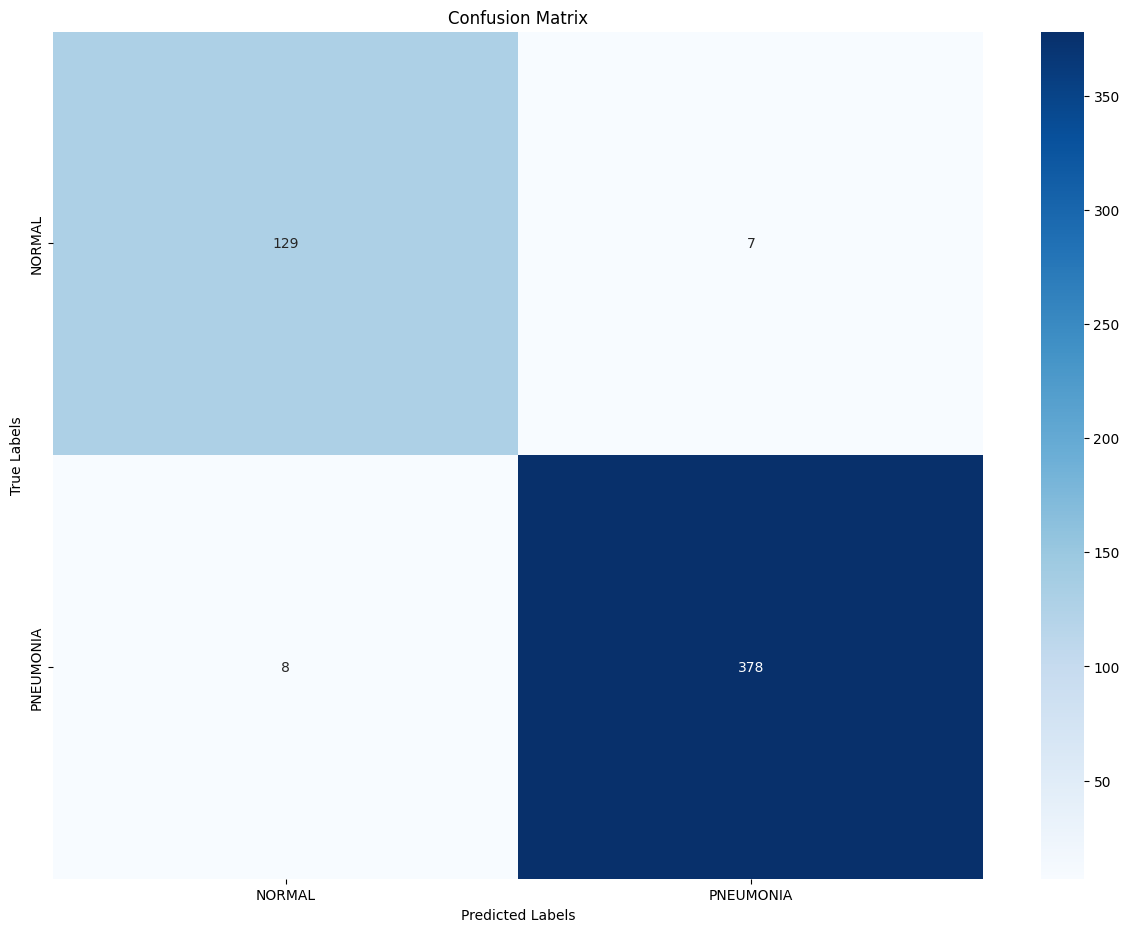

In [45]:
# Confusion Matrix
matrix = confusion_matrix(true_labels, test_predictions.argmax(axis=1))

# Visualization
plt.figure(figsize=(15, 11))
sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(),
            yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# **DenseNet121**

In [46]:
# Load the pre-trained DenseNet121 model without the top classification layer
base_model_DenseNet121 = DenseNet121(weights='imagenet', include_top=False, input_shape=(image_height, image_width, 3))

# Set the layers of the base model as non-trainable (freeze them)
for layer in base_model_DenseNet121.layers:
    layer.trainable = False

# Create a new model and add the DenseNet121 base model
model_DenseNet121 = Sequential()
model_DenseNet121.add(base_model_DenseNet121)

# Add a custom top layer for classification
model_DenseNet121.add(GlobalAveragePooling2D())
model_DenseNet121.add(Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.001)))
model_DenseNet121.add(Dropout(0.4))
model_DenseNet121.add(Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.001)))
model_DenseNet121.add(Dropout(0.2))
model_DenseNet121.add(Dense(2, activation='softmax'))

# Model summary
print("DenseNet121 Model")
model_DenseNet121.summary()

DenseNet121 Model
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 global_average_pooling2d_6   (None, 1024)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_18 (Dense)            (None, 128)               131200    
                                                                 
 dropout_12 (Dropout)        (None, 128)               0         
                                                                 
 dense_19 (Dense)            (None, 64)                8256      
                                                                 
 dropout_13 (Dropout)        (None, 64)                0         
                                    

In [47]:
# Compile the model
model_DenseNet121.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history_DenseNet121 = model_DenseNet121.fit(train_data, epochs=EPOCHS, validation_data=val_generator, callbacks=[early_stopping], class_weight=class_weights)

Epoch 1/10
522/522 [==============================] - 85s 153ms/step - loss: 0.3771 - accuracy: 0.8939 - val_loss: 0.3157 - val_accuracy: 0.9119
Epoch 2/10
522/522 [==============================] - 78s 150ms/step - loss: 0.2574 - accuracy: 0.9258 - val_loss: 0.1959 - val_accuracy: 0.9425
Epoch 3/10
522/522 [==============================] - 77s 146ms/step - loss: 0.2155 - accuracy: 0.9384 - val_loss: 0.1529 - val_accuracy: 0.9579
Epoch 4/10
522/522 [==============================] - 77s 147ms/step - loss: 0.1945 - accuracy: 0.9426 - val_loss: 0.1859 - val_accuracy: 0.9406
Epoch 5/10
522/522 [==============================] - 77s 148ms/step - loss: 0.1834 - accuracy: 0.9421 - val_loss: 0.1779 - val_accuracy: 0.9406
Epoch 6/10
522/522 [==============================] - 78s 149ms/step - loss: 0.1825 - accuracy: 0.9430 - val_loss: 0.1432 - val_accuracy: 0.9617
Epoch 7/10
522/522 [==============================] - 77s 147ms/step - loss: 0.1799 - accuracy: 0.9439 - val_loss: 0.1399 - val_ac

In [48]:
# Validate the model
val_loss_DenseNet121, val_accuracy_DenseNet121 = model_DenseNet121.evaluate(val_generator, steps=len(val_generator))
print(f'Validation Loss: {val_loss_DenseNet121:.4f}')
print(f'Validation Accuracy: {val_accuracy_DenseNet121:.4f}')

33/33 [==============================] - 4s 130ms/step - loss: 0.1432 - accuracy: 0.9617
Validation Loss: 0.1432
Validation Accuracy: 0.9617


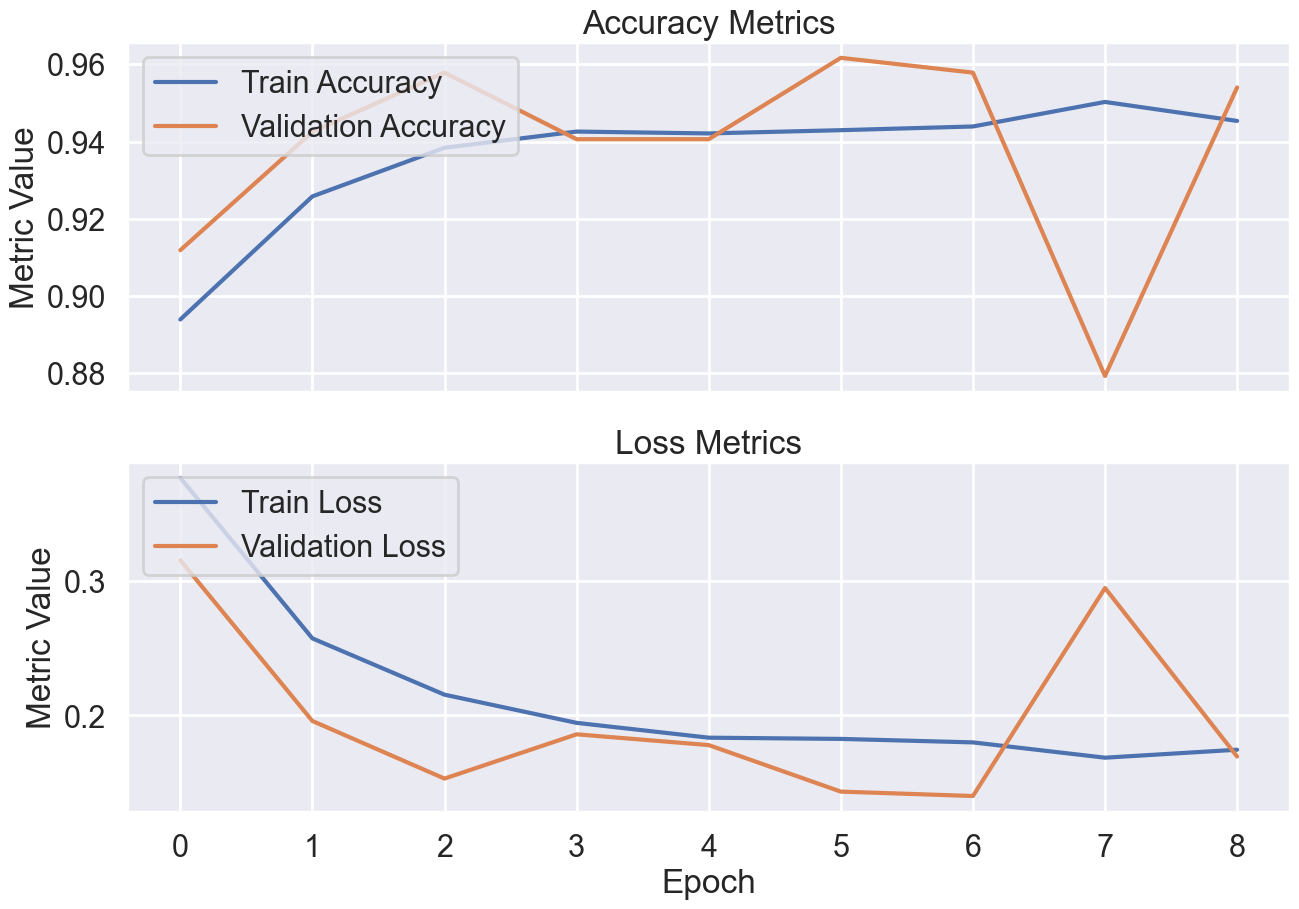

In [111]:
# Visualize training progression
sns.set_theme()
sns.set_context("poster")

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10), dpi=100, sharex=True)

ax1.plot(history_DenseNet121.history['accuracy'], label='Train Accuracy')
ax1.plot(history_DenseNet121.history['val_accuracy'], label='Validation Accuracy')
ax1.set_title('Accuracy Metrics')
ax1.set_ylabel('Metric Value')
ax1.legend(loc='upper left')

ax2.plot(history_DenseNet121.history['loss'], label='Train Loss')
ax2.plot(history_DenseNet121.history['val_loss'], label='Validation Loss')
ax2.set_title('Loss Metrics')
ax2.set_ylabel('Metric Value')
ax2.set_xlabel('Epoch')
ax2.legend(loc='upper left')

plt.show()

In [112]:
# Test the model
test_results = model_DenseNet121.evaluate(test_generator)
test_predictions = model_DenseNet121.predict(test_generator)
true_labels = test_generator.labels

# Calculate values for roc curve analysis
test_proba = test_predictions[:, 1]
fpr, tpr, _ = roc_curve(true_labels, test_proba)

# Store values for later
roc_data["DenseNet121"] = (fpr, tpr, auc(fpr, tpr))

# Create classification report for model
report = classification_report(true_labels, test_predictions.argmax(axis=1), digits=5)
print(report)

33/33 [==============================] - 4s 118ms/step
              precision    recall  f1-score   support

           0    0.89041   0.95588   0.92199       136
           1    0.98404   0.95855   0.97113       386

    accuracy                        0.95785       522
   macro avg    0.93723   0.95722   0.94656       522
weighted avg    0.95965   0.95785   0.95833       522



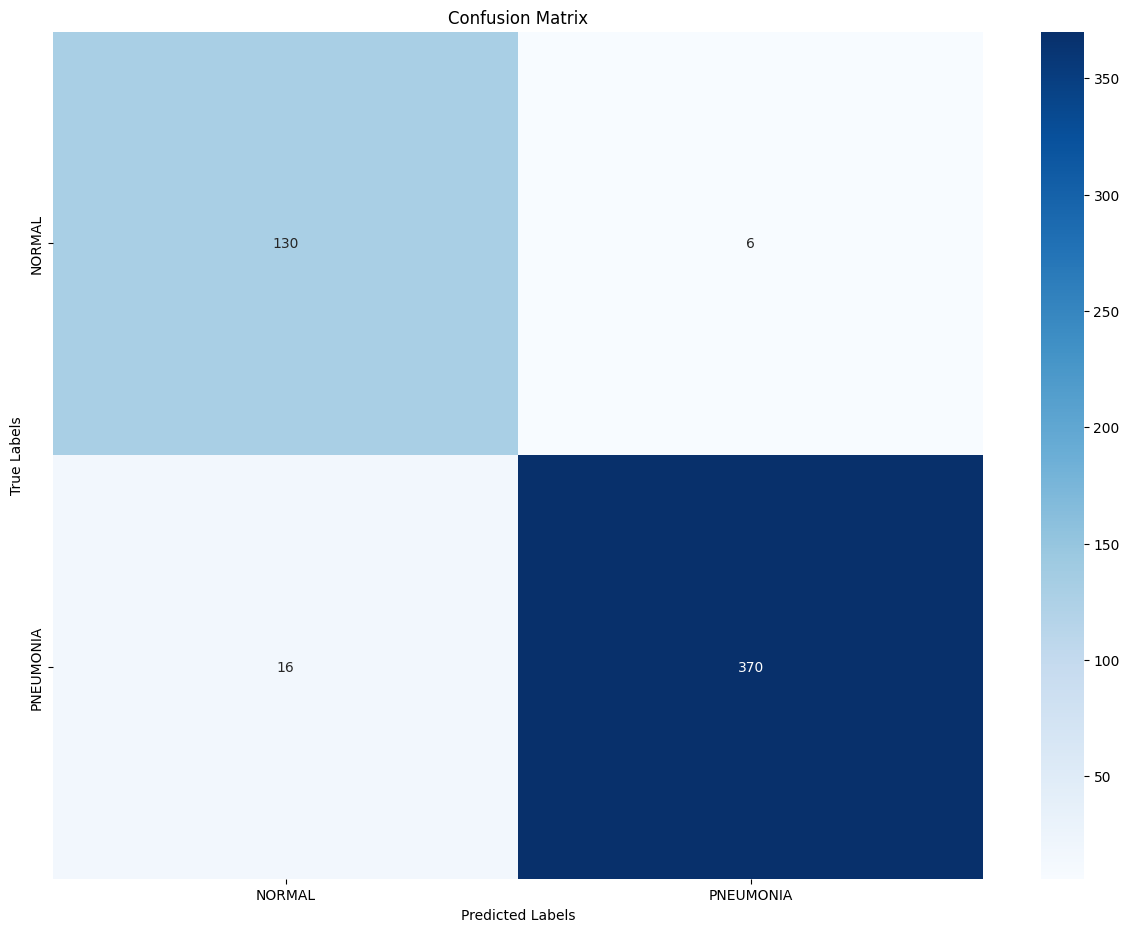

In [50]:
# Confusion Matrix
matrix = confusion_matrix(true_labels, test_predictions.argmax(axis=1))

# Visualization
plt.figure(figsize=(15, 11))
sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(),
            yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# **Xception**

In [51]:
# Load the pre-trained Xception model without the top classification layer
base_model_Xception = Xception(weights='imagenet', include_top=False, input_shape=(image_height, image_width, 3))

# Set the layers of the base model as non-trainable (freeze them)
for layer in base_model_Xception.layers:
    layer.trainable = False

# Create a new model and add the Xception base model
model_Xception = Sequential()
model_Xception.add(base_model_Xception)

# Add a custom top layer for classification
model_Xception.add(GlobalAveragePooling2D())
model_Xception.add(Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.001)))
model_Xception.add(Dropout(0.4))
model_Xception.add(Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.001)))
model_Xception.add(Dropout(0.2))
model_Xception.add(Dense(2, activation='softmax'))

# Model summary
print("Xception Model")
model_Xception.summary()

Xception Model
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 global_average_pooling2d_7   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_21 (Dense)            (None, 128)               262272    
                                                                 
 dropout_14 (Dropout)        (None, 128)               0         
                                                                 
 dense_22 (Dense)            (None, 64)                8256      
                                                                 
 dropout_15 (Dropout)        (None, 64)                0         
                                       

In [52]:
# Compile the model
model_Xception.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history_Xception = model_Xception.fit(train_data, epochs=EPOCHS, validation_data=val_generator, callbacks=[early_stopping], class_weight=class_weights)

Epoch 1/10
522/522 [==============================] - 76s 142ms/step - loss: 0.3841 - accuracy: 0.9026 - val_loss: 0.3380 - val_accuracy: 0.8927
Epoch 2/10
522/522 [==============================] - 74s 142ms/step - loss: 0.2677 - accuracy: 0.9250 - val_loss: 0.1955 - val_accuracy: 0.9540
Epoch 3/10
522/522 [==============================] - 73s 140ms/step - loss: 0.2339 - accuracy: 0.9317 - val_loss: 0.2580 - val_accuracy: 0.9138
Epoch 4/10
522/522 [==============================] - 73s 140ms/step - loss: 0.2158 - accuracy: 0.9402 - val_loss: 0.1622 - val_accuracy: 0.9617
Epoch 5/10
522/522 [==============================] - 76s 146ms/step - loss: 0.2081 - accuracy: 0.9419 - val_loss: 0.1799 - val_accuracy: 0.9579
Epoch 6/10
522/522 [==============================] - 75s 144ms/step - loss: 0.1970 - accuracy: 0.9464 - val_loss: 0.3353 - val_accuracy: 0.8851
Epoch 7/10
522/522 [==============================] - 77s 147ms/step - loss: 0.1938 - accuracy: 0.9446 - val_loss: 0.2591 - val_ac

In [53]:
# Validate the model
val_loss_Xception, val_accuracy_Xception = model_Xception.evaluate(val_generator, steps=len(val_generator))
print(f'Validation Loss: {val_loss_Xception:.4f}')
print(f'Validation Accuracy: {val_accuracy_Xception:.4f}')

33/33 [==============================] - 4s 111ms/step - loss: 0.1622 - accuracy: 0.9617
Validation Loss: 0.1622
Validation Accuracy: 0.9617


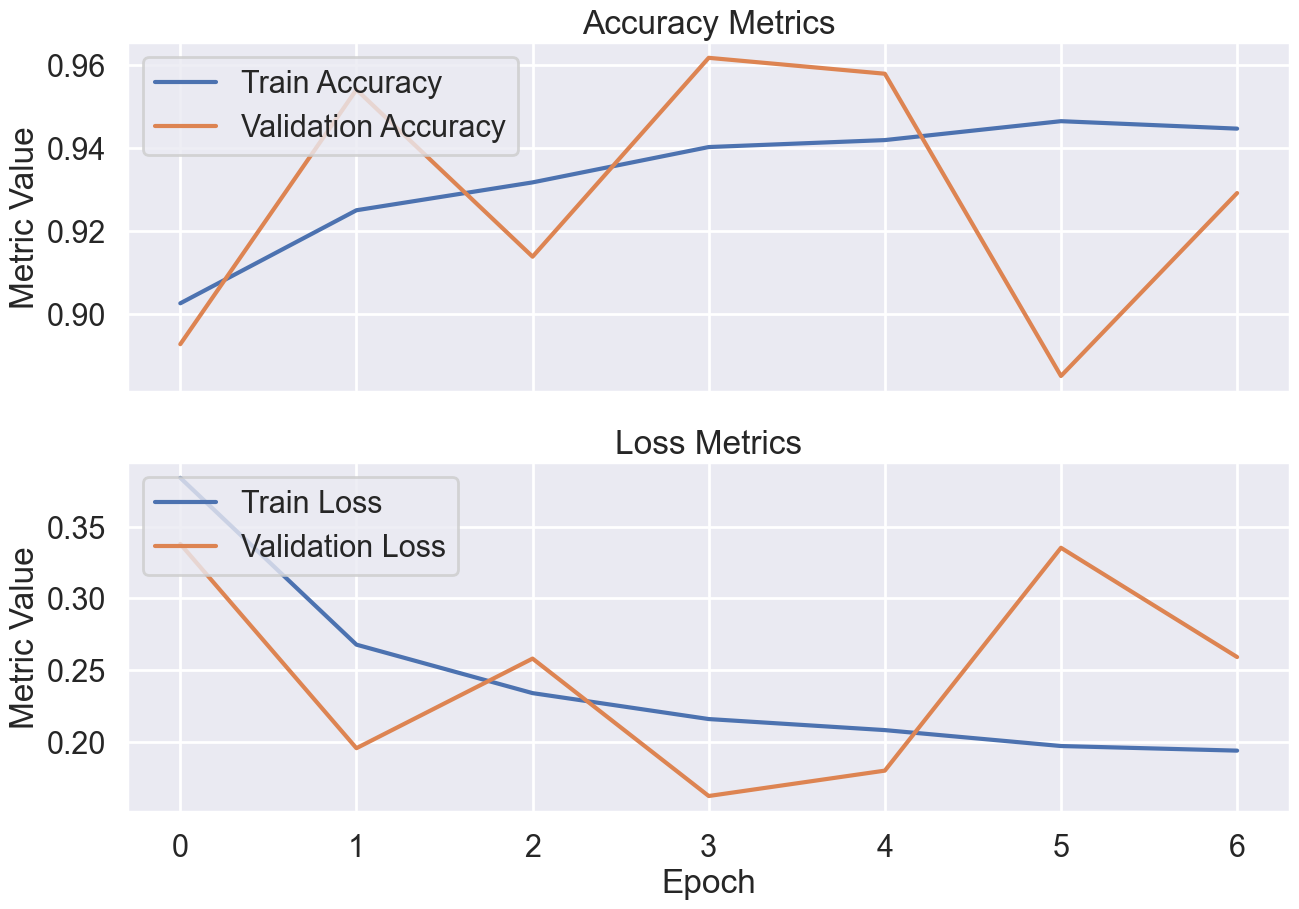

In [113]:
# Visualize training progression
sns.set_theme()
sns.set_context("poster")

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10), dpi=100, sharex=True)

ax1.plot(history_Xception.history['accuracy'], label='Train Accuracy')
ax1.plot(history_Xception.history['val_accuracy'], label='Validation Accuracy')
ax1.set_title('Accuracy Metrics')
ax1.set_ylabel('Metric Value')
ax1.legend(loc='upper left')

ax2.plot(history_Xception.history['loss'], label='Train Loss')
ax2.plot(history_Xception.history['val_loss'], label='Validation Loss')
ax2.set_title('Loss Metrics')
ax2.set_ylabel('Metric Value')
ax2.set_xlabel('Epoch')
ax2.legend(loc='upper left')

plt.show()

In [114]:
# Test the model
test_results = model_Xception.evaluate(test_generator)
test_predictions = model_Xception.predict(test_generator)
true_labels = test_generator.labels

# Calculate values for roc curve analysis
test_proba = test_predictions[:, 1]
fpr, tpr, _ = roc_curve(true_labels, test_proba)

# Store values for later
roc_data["Xception"] = (fpr, tpr, auc(fpr, tpr))

# Create classification report for model
report = classification_report(true_labels, test_predictions.argmax(axis=1), digits=5)
print(report)

33/33 [==============================] - 4s 107ms/step
              precision    recall  f1-score   support

           0    0.89286   0.91912   0.90580       136
           1    0.97120   0.96114   0.96615       386

    accuracy                        0.95019       522
   macro avg    0.93203   0.94013   0.93597       522
weighted avg    0.95079   0.95019   0.95042       522



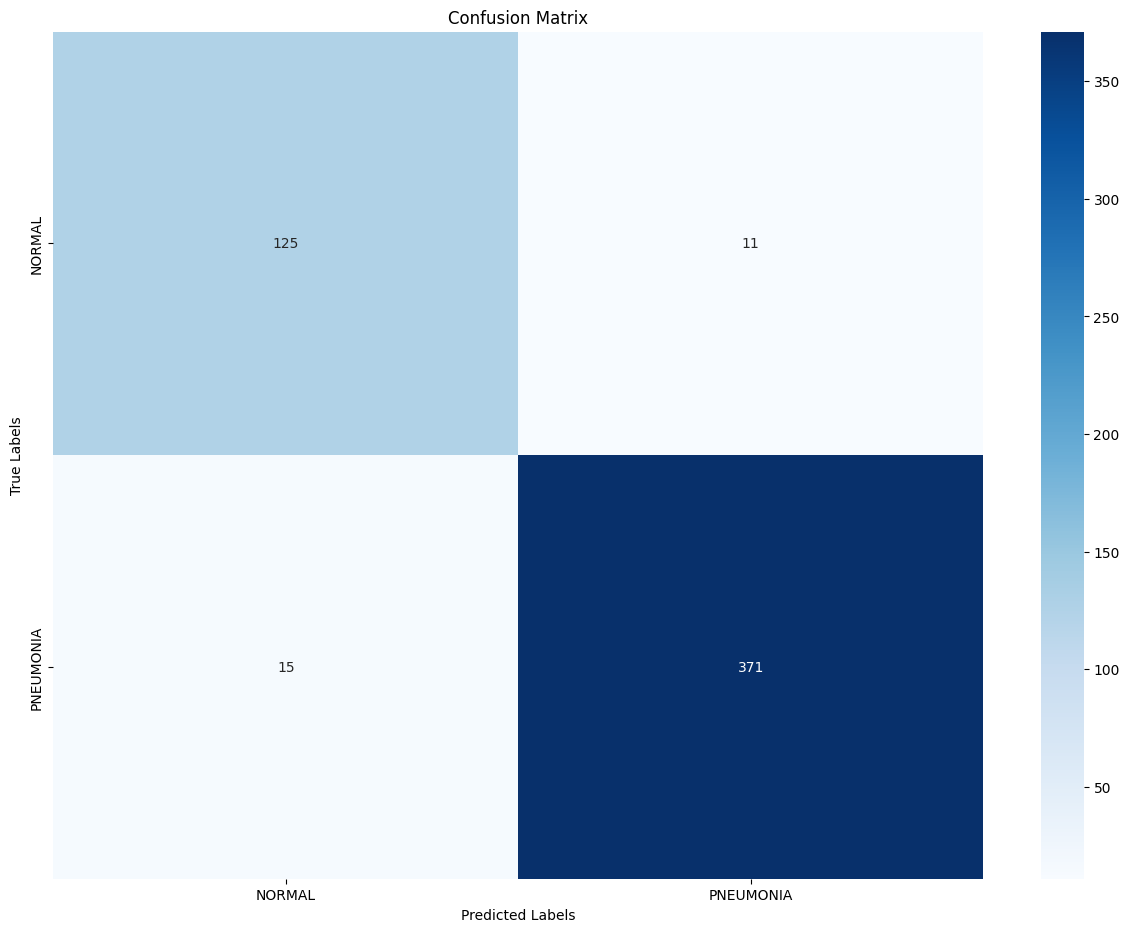

In [55]:
# Confusion Matrix
matrix = confusion_matrix(true_labels, test_predictions.argmax(axis=1))

# Visualization
plt.figure(figsize=(15, 11))
sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(),
            yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# **EfficientNetB0**

In [56]:
# Load the pre-trained EfficientNetB0 model without the top classification layer
base_model_EfficientNetB0 = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(image_height, image_width, 3), pooling='max')

# Set the layers of the base model as non-trainable (freeze them)
for layer in base_model_EfficientNetB0.layers:
    layer.trainable = False

# Create a new model and add the EfficientNetB0 base model
model_EfficientNetB0 = Sequential()
model_EfficientNetB0.add(base_model_EfficientNetB0)

# Add a custom top layer for classification
model_EfficientNetB0.add(BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001))
model_EfficientNetB0.add(Dense(256, kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.006),
                                bias_regularizer= regularizers.l1(0.006), activation= 'relu'))
model_EfficientNetB0.add(Dropout(rate=0.45, seed=42))
model_EfficientNetB0.add(Dense(2, activation='softmax'))

# Model summary
print("EfficientNetB0 Model")
model_EfficientNetB0.summary()

EfficientNetB0 Model
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 1280)             4049571   
                                                                 
 batch_normalization_301 (Ba  (None, 1280)             5120      
 tchNormalization)                                               
                                                                 
 dense_24 (Dense)            (None, 256)               327936    
                                                                 
 dropout_16 (Dropout)        (None, 256)               0         
                                                                 
 dense_25 (Dense)            (None, 2)                 514       
                                                                 
Total params: 4,383,141
Trainable params: 331,010
Non-trainable params: 4,052,131
_________________

In [57]:
# Compile the model
model_EfficientNetB0.compile(optimizer=Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history_EfficientNetB0 = model_EfficientNetB0.fit(train_data_unrescaled, epochs=EPOCHS, validation_data=val_generator_unrescaled, callbacks=[early_stopping], class_weight=class_weights)

Epoch 1/10
522/522 [==============================] - 82s 148ms/step - loss: 4.0476 - accuracy: 0.9005 - val_loss: 2.3768 - val_accuracy: 0.9425
Epoch 2/10
522/522 [==============================] - 76s 146ms/step - loss: 1.7310 - accuracy: 0.9298 - val_loss: 1.2486 - val_accuracy: 0.9253
Epoch 3/10
522/522 [==============================] - 71s 137ms/step - loss: 0.9416 - accuracy: 0.9437 - val_loss: 0.7443 - val_accuracy: 0.9444
Epoch 4/10
522/522 [==============================] - 72s 137ms/step - loss: 0.6058 - accuracy: 0.9475 - val_loss: 0.5120 - val_accuracy: 0.9464
Epoch 5/10
522/522 [==============================] - 72s 138ms/step - loss: 0.4448 - accuracy: 0.9527 - val_loss: 0.3803 - val_accuracy: 0.9579
Epoch 6/10
522/522 [==============================] - 72s 139ms/step - loss: 0.3666 - accuracy: 0.9545 - val_loss: 0.3305 - val_accuracy: 0.9540
Epoch 7/10
522/522 [==============================] - 73s 140ms/step - loss: 0.3211 - accuracy: 0.9564 - val_loss: 0.2955 - val_ac

In [58]:
# Validate the model
val_loss_EfficientNetB0, val_accuracy_EfficientNetB0 = model_EfficientNetB0.evaluate(val_generator_unrescaled, steps=len(val_generator_unrescaled))
print(f'Validation Loss: {val_loss_EfficientNetB0:.4f}')
print(f'Validation Accuracy: {val_accuracy_EfficientNetB0:.4f}')

33/33 [==============================] - 3s 88ms/step - loss: 0.3803 - accuracy: 0.9579
Validation Loss: 0.3803
Validation Accuracy: 0.9579


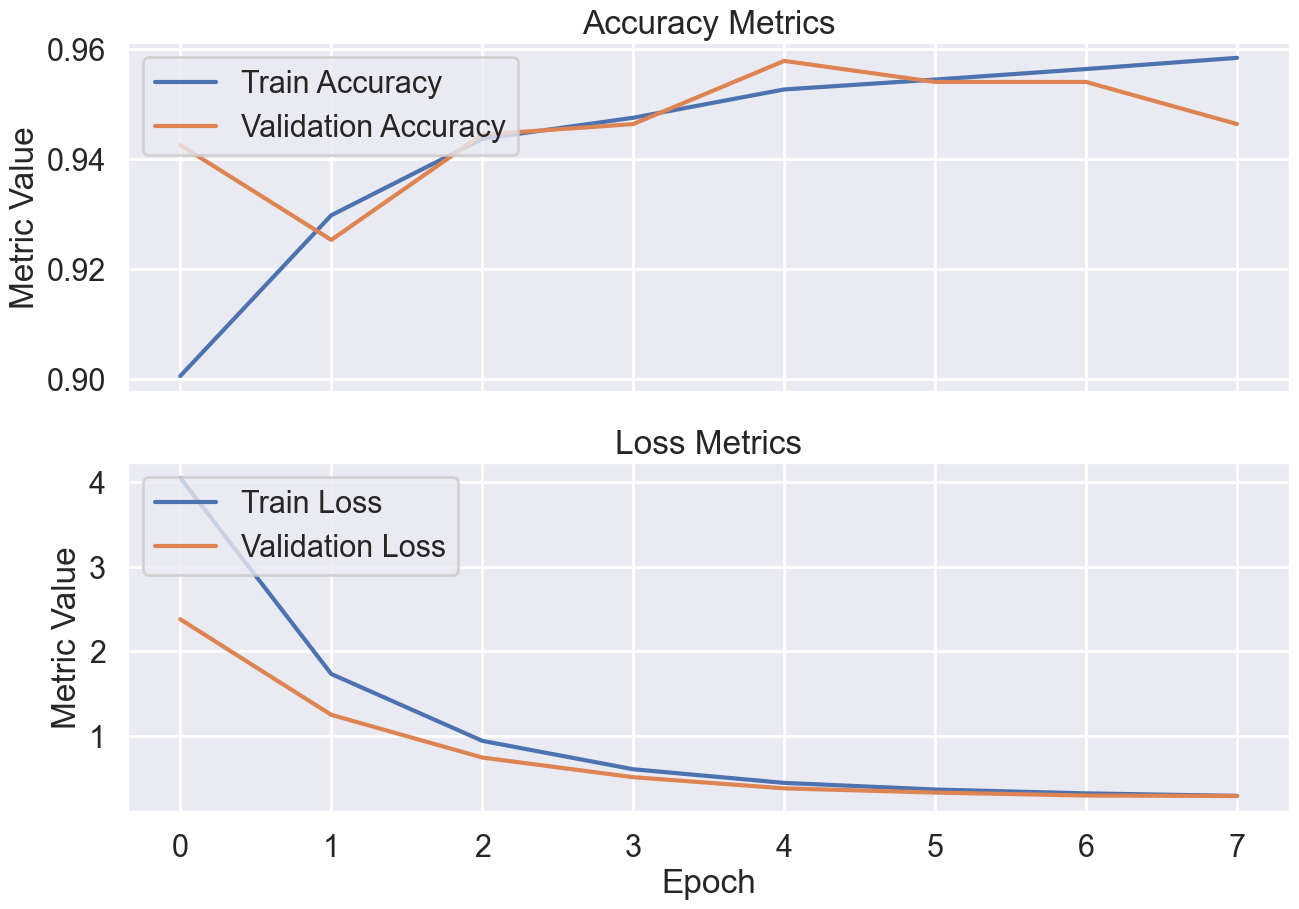

In [115]:
# Visualize training progression
sns.set_theme()
sns.set_context("poster")

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10), dpi=100, sharex=True)

ax1.plot(history_EfficientNetB0.history['accuracy'], label='Train Accuracy')
ax1.plot(history_EfficientNetB0.history['val_accuracy'], label='Validation Accuracy')
ax1.set_title('Accuracy Metrics')
ax1.set_ylabel('Metric Value')
ax1.legend(loc='upper left')

ax2.plot(history_EfficientNetB0.history['loss'], label='Train Loss')
ax2.plot(history_EfficientNetB0.history['val_loss'], label='Validation Loss')
ax2.set_title('Loss Metrics')
ax2.set_ylabel('Metric Value')
ax2.set_xlabel('Epoch')
ax2.legend(loc='upper left')

plt.show()

In [116]:
# Test the model
test_results = model_EfficientNetB0.evaluate(test_generator_unrescaled)
test_predictions = model_EfficientNetB0.predict(test_generator_unrescaled)
true_labels = test_generator_unrescaled.labels

# Calculate values for roc curve analysis
test_proba = test_predictions[:, 1]
fpr, tpr, _ = roc_curve(true_labels, test_proba)

# Store values for later
roc_data["EfficientNetB0"] = (fpr, tpr, auc(fpr, tpr))

# Create classification report for model
report = classification_report(true_labels, test_predictions.argmax(axis=1), digits=5)
print(report)

33/33 [==============================] - 3s 93ms/step
              precision    recall  f1-score   support

           0    0.84906   0.99265   0.91525       136
           1    0.99725   0.93782   0.96662       386

    accuracy                        0.95211       522
   macro avg    0.92315   0.96524   0.94094       522
weighted avg    0.95864   0.95211   0.95324       522



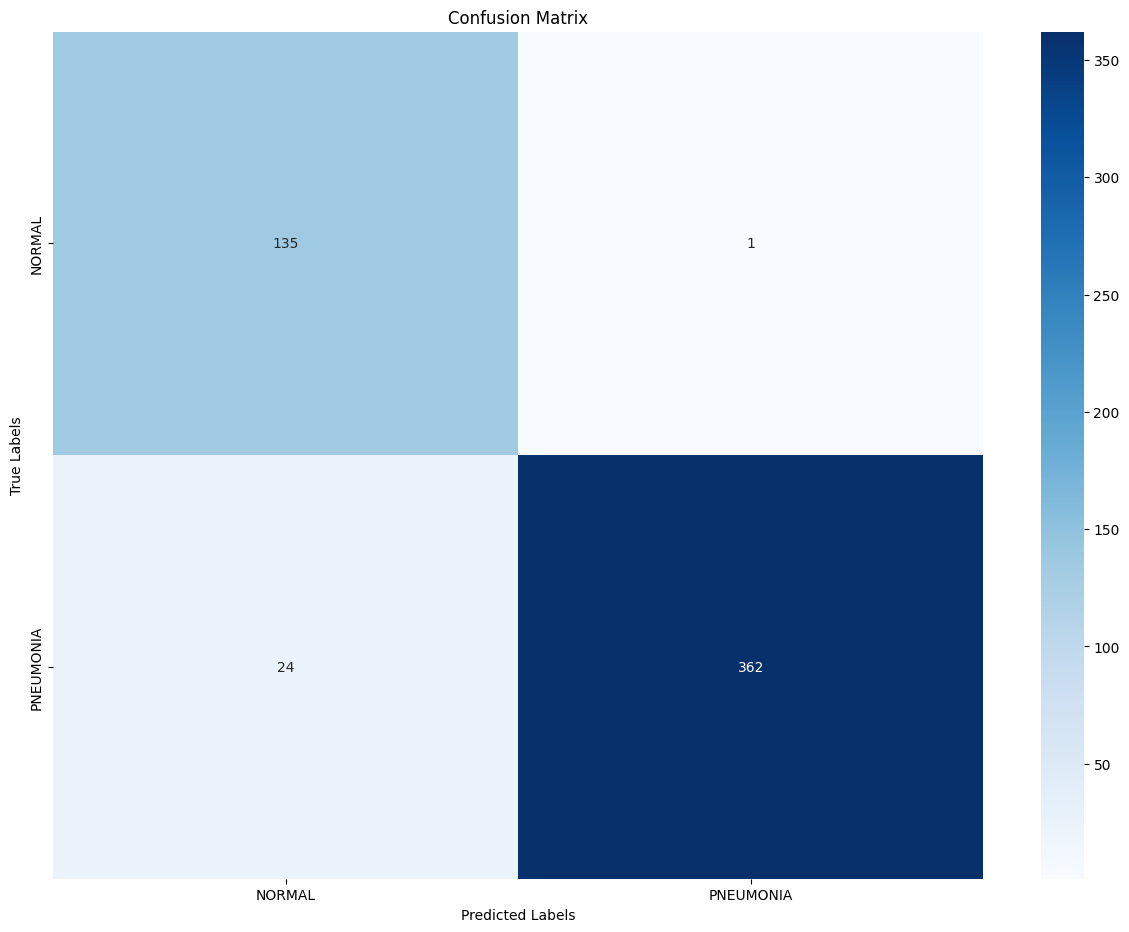

In [60]:
# Confusion Matrix
matrix = confusion_matrix(true_labels, test_predictions.argmax(axis=1))

# Visualization
plt.figure(figsize=(15, 11))
sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator_unrescaled.class_indices.keys(),
            yticklabels=test_generator_unrescaled.class_indices.keys())
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# **EfficientNetB5**

In [61]:
# Load the pre-trained EfficientNetB5 model without the top classification layer
base_model_EfficientNetB5 = EfficientNetB5(weights='imagenet', include_top=False, input_shape=(image_height, image_width, 3), pooling="max")

# Set the layers of the base model as non-trainable (freeze them)
for layer in base_model_EfficientNetB5.layers:
    layer.trainable = False

# Create a new model and add the EfficientNetB5 base model
model_EfficientNetB5 = Sequential()
model_EfficientNetB5.add(base_model_EfficientNetB5)

# Add a custom top layer for classification
model_EfficientNetB5.add(BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001))
model_EfficientNetB5.add(Dense(256, kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.006),
                                bias_regularizer= regularizers.l1(0.006), activation= 'relu'))
model_EfficientNetB5.add(Dropout(rate=0.45, seed=42))
model_EfficientNetB5.add(Dense(2, activation='softmax'))

# Model summary
print("EfficientNetB5 Model")
model_EfficientNetB5.summary()

EfficientNetB5 Model
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb5 (Functional)  (None, 2048)             28513527  
                                                                 
 batch_normalization_302 (Ba  (None, 2048)             8192      
 tchNormalization)                                               
                                                                 
 dense_26 (Dense)            (None, 256)               524544    
                                                                 
 dropout_17 (Dropout)        (None, 256)               0         
                                                                 
 dense_27 (Dense)            (None, 2)                 514       
                                                                 
Total params: 29,046,777
Trainable params: 529,154
Non-trainable params: 28,517,623
_______________

In [62]:
# Compile the model
model_EfficientNetB5.compile(optimizer=Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history_EfficientNetB5 = model_EfficientNetB5.fit(train_data_unrescaled, epochs=EPOCHS, validation_data=val_generator_unrescaled, callbacks=[early_stopping], class_weight=class_weights)

Epoch 1/10
522/522 [==============================] - 101s 174ms/step - loss: 4.8444 - accuracy: 0.8794 - val_loss: 3.0239 - val_accuracy: 0.9195
Epoch 2/10
522/522 [==============================] - 88s 169ms/step - loss: 2.2116 - accuracy: 0.9148 - val_loss: 1.5865 - val_accuracy: 0.9234
Epoch 3/10
522/522 [==============================] - 87s 167ms/step - loss: 1.2224 - accuracy: 0.9259 - val_loss: 0.9665 - val_accuracy: 0.9330
Epoch 4/10
522/522 [==============================] - 86s 165ms/step - loss: 0.7869 - accuracy: 0.9288 - val_loss: 0.7137 - val_accuracy: 0.9138
Epoch 5/10
522/522 [==============================] - 88s 168ms/step - loss: 0.5728 - accuracy: 0.9362 - val_loss: 0.5368 - val_accuracy: 0.9253
Epoch 6/10
522/522 [==============================] - 86s 164ms/step - loss: 0.4734 - accuracy: 0.9346 - val_loss: 0.5203 - val_accuracy: 0.8889
Epoch 6: early stopping


In [63]:
# Validate the model
val_loss_EfficientNetB5, val_accuracy_EfficientNetB5 = model_EfficientNetB5.evaluate(val_generator_unrescaled, steps=len(val_generator_unrescaled))
print(f'Validation Loss: {val_loss_EfficientNetB5:.4f}')
print(f'Validation Accuracy: {val_accuracy_EfficientNetB5:.4f}')

33/33 [==============================] - 6s 169ms/step - loss: 0.9665 - accuracy: 0.9330
Validation Loss: 0.9665
Validation Accuracy: 0.9330


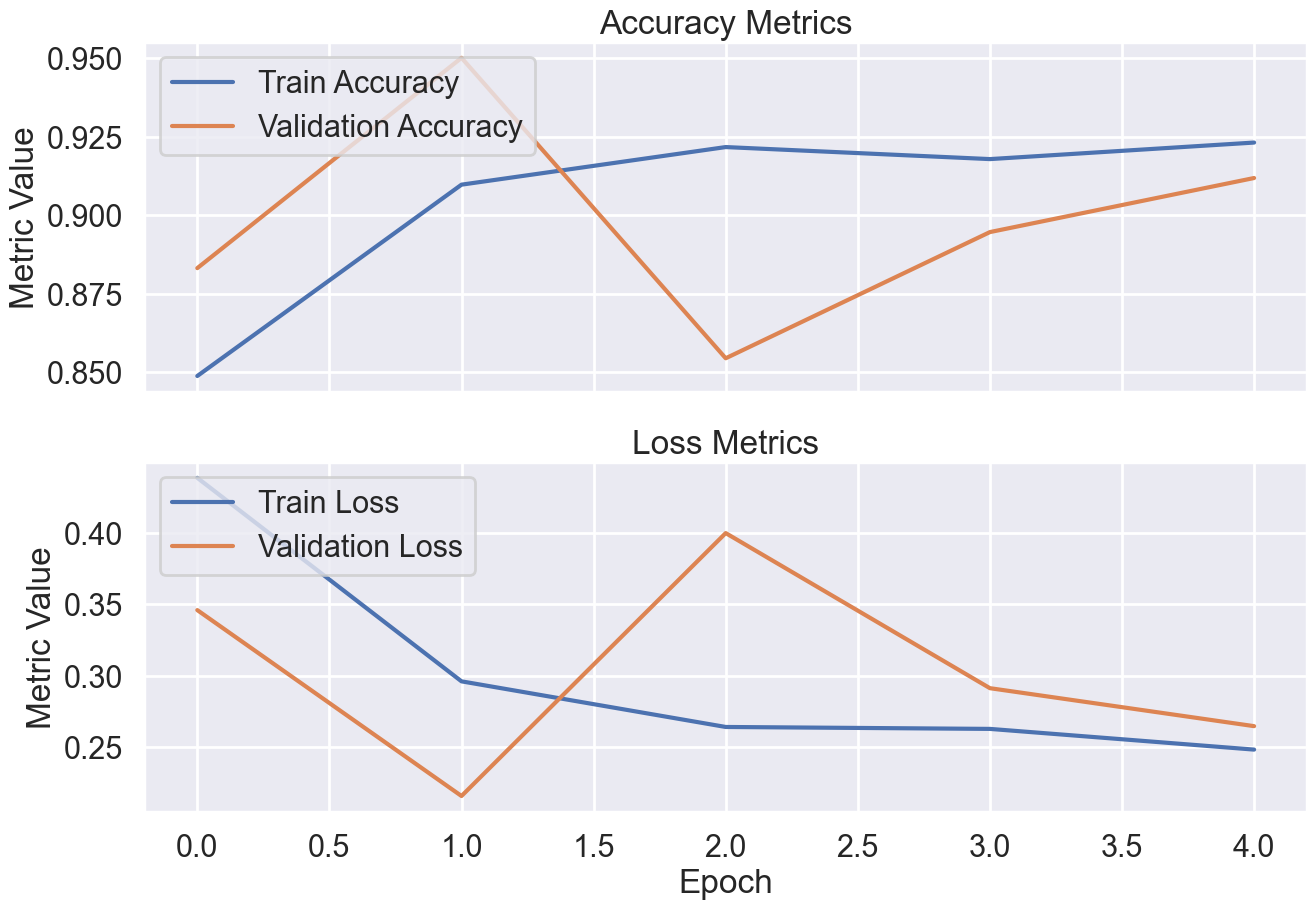

In [117]:
# Visualize training progression
sns.set_theme()
sns.set_context("poster")

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10), dpi=100, sharex=True)

ax1.plot(history_VGG16.history['accuracy'], label='Train Accuracy')
ax1.plot(history_VGG16.history['val_accuracy'], label='Validation Accuracy')
ax1.set_title('Accuracy Metrics')
ax1.set_ylabel('Metric Value')
ax1.legend(loc='upper left')

ax2.plot(history_VGG16.history['loss'], label='Train Loss')
ax2.plot(history_VGG16.history['val_loss'], label='Validation Loss')
ax2.set_title('Loss Metrics')
ax2.set_ylabel('Metric Value')
ax2.set_xlabel('Epoch')
ax2.legend(loc='upper left')

plt.show()

In [118]:
# Test the model
test_results = model_EfficientNetB5.evaluate(test_generator_unrescaled)
test_predictions = model_EfficientNetB5.predict(test_generator_unrescaled)
true_labels = test_generator_unrescaled.labels

# Calculate values for roc curve analysis
test_proba = test_predictions[:, 1]
fpr, tpr, _ = roc_curve(true_labels, test_proba)

# Store values for later
roc_data["EfficientNetB5"] = (fpr, tpr, auc(fpr, tpr))

# Create classification report for model
report = classification_report(true_labels, test_predictions.argmax(axis=1), digits=5)
print(report)

33/33 [==============================] - 5s 156ms/step
              precision    recall  f1-score   support

           0    0.78488   0.99265   0.87662       136
           1    0.99714   0.90415   0.94837       386

    accuracy                        0.92720       522
   macro avg    0.89101   0.94840   0.91250       522
weighted avg    0.94184   0.92720   0.92968       522



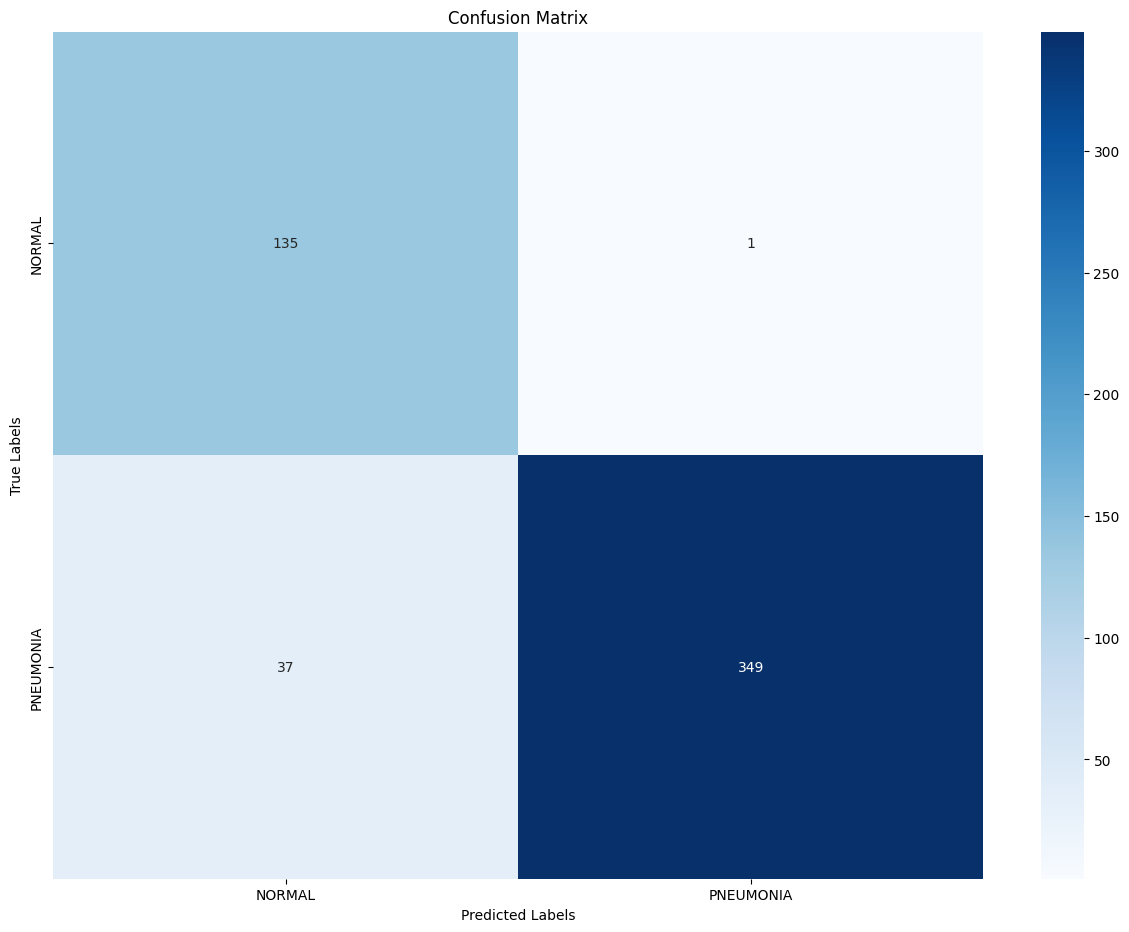

In [65]:
# Confusion Matrix
matrix = confusion_matrix(true_labels, test_predictions.argmax(axis=1))

# Visualization
plt.figure(figsize=(15, 11))
sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator_unrescaled.class_indices.keys(),
            yticklabels=test_generator_unrescaled.class_indices.keys())
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# **Model Performance Comparison**

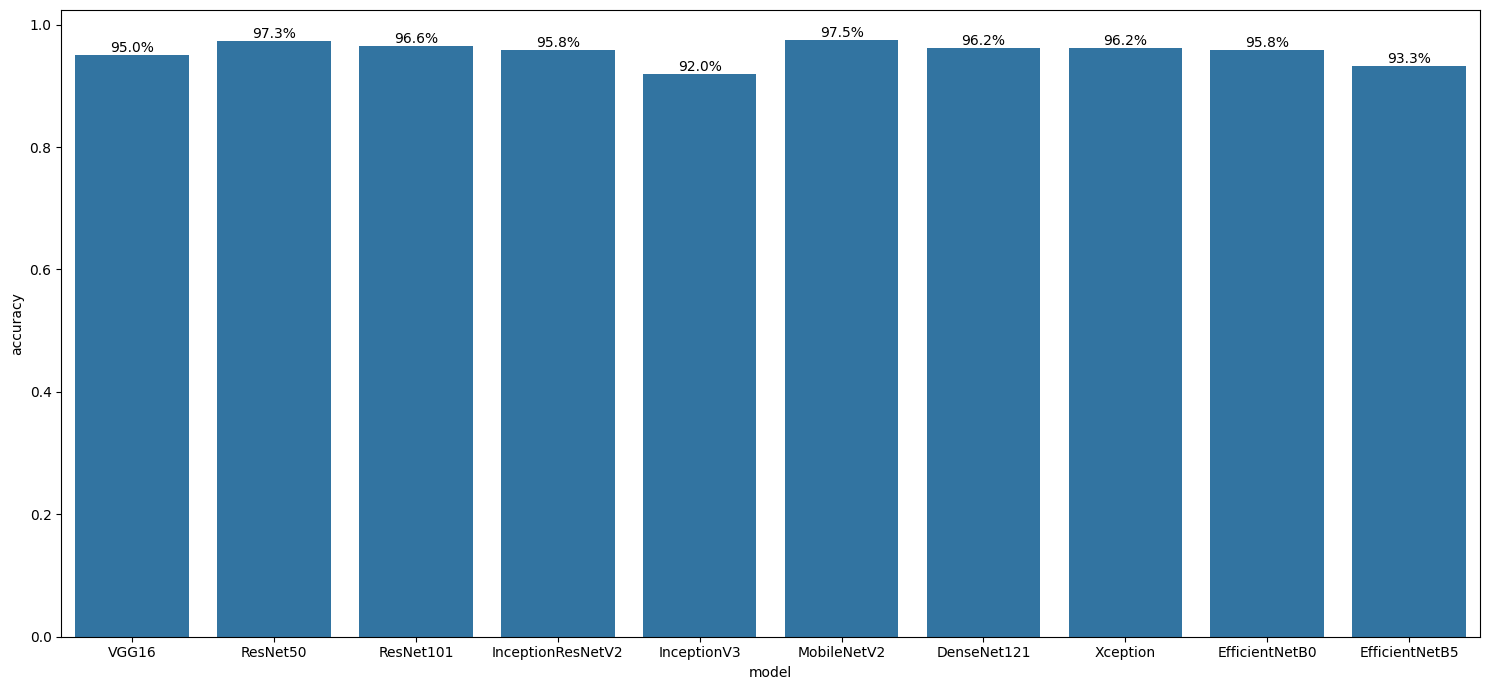

In [71]:
# Collect accuracy data of each model
performance_data = {
    'VGG16': val_accuracy_VGG16, 
    'ResNet50': val_accuracy_ResNet50,
    'ResNet101': val_accuracy_ResNet101,
    'InceptionResNetV2': val_accuracy_InceptionResNetV2,
    'InceptionV3': val_accuracy_InceptionV3,
    'MobileNetV2': val_accuracy_MobileNetV2,
    'DenseNet121': val_accuracy_DenseNet121,
    'Xception': val_accuracy_Xception,
    'EfficientNetB0': val_accuracy_EfficientNetB0,
    'EfficientNetB5': val_accuracy_EfficientNetB5
}

# Create dataframe
performance_df = pd.DataFrame.from_dict(performance_data, orient='index', columns=['accuracy'])
performance_df = performance_df.reset_index().rename(columns={'index': 'model'})

# Set chart size
plt.figure(figsize=(15,7))

# Create bar chart
sns.barplot(x='model', y='accuracy', data=performance_df)

# Add labels to bars
ax = plt.gca()
for bar in ax.containers:
    ax.bar_label(bar, label_type='edge', labels=[f"{x:.1%}" for x in bar.datavalues], fontsize=10)

# Adjust the layout
plt.tight_layout()

plt.show()

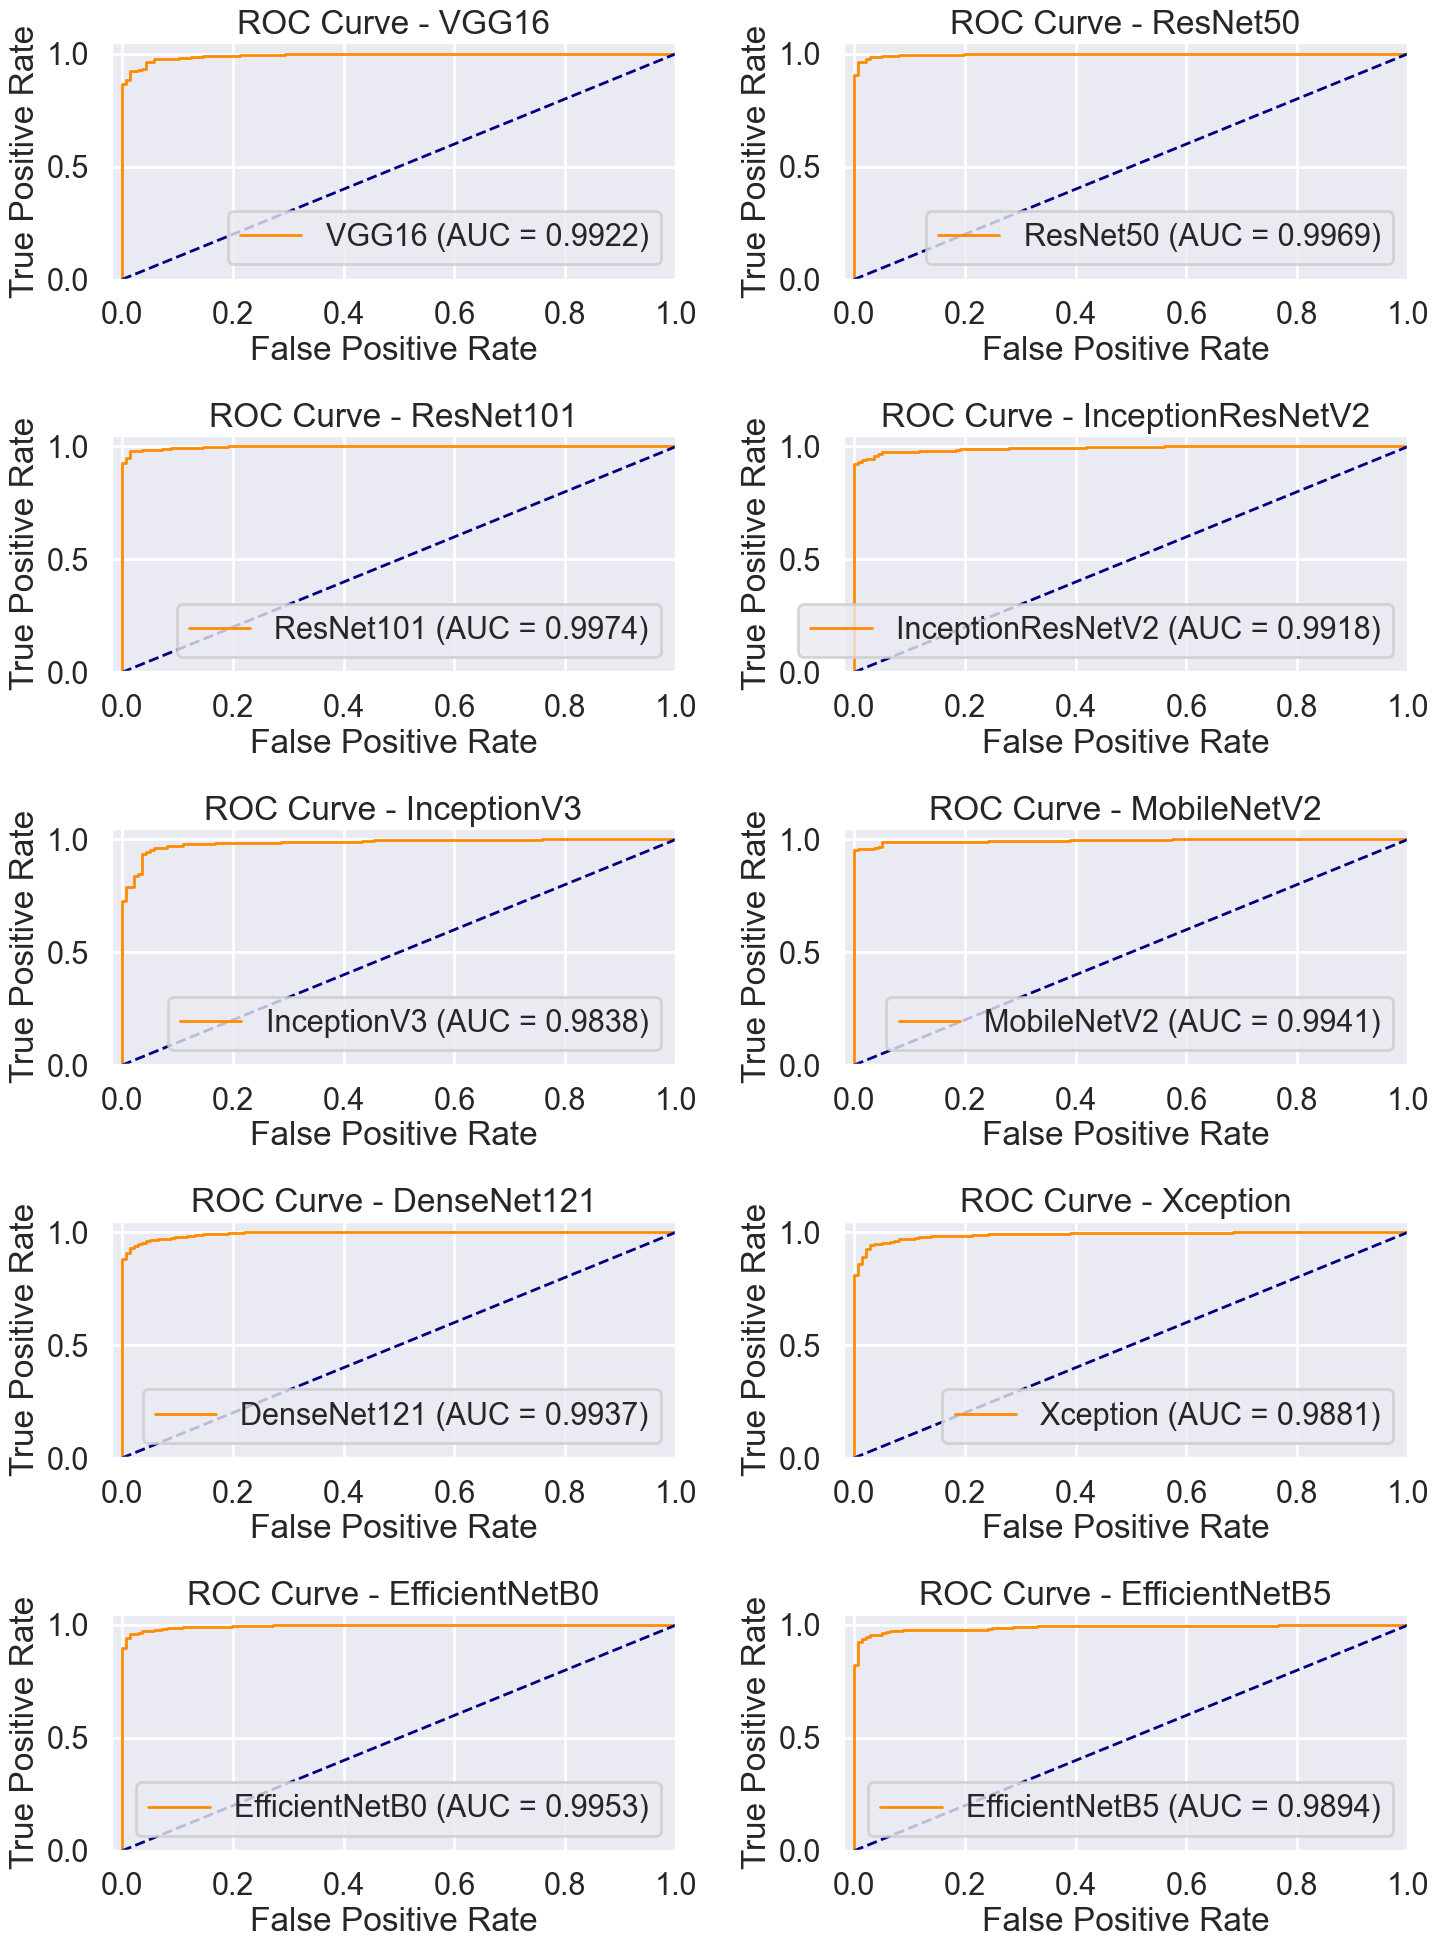

In [126]:
# Create subplot for ROC Curve
fig, axes = plt.subplots(5, 2, figsize=(15, 20))

# Subplot content
for i, (model_name, _) in enumerate(performance_data.items()):
    ax = axes[i // 2, i % 2]
    fpr, tpr, roc_auc = roc_data[model_name]

    ax.plot(fpr, tpr, color='darkorange', lw=2, label=f'{model_name} (AUC = {roc_auc:.4f})')
    ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax.set_xlim([-0.02, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'ROC Curve - {model_name}')
    ax.legend(loc='lower right')
    ax.grid(True)

# Adjust the layout
plt.tight_layout()

plt.show()